## Analysis of Perfect Preview Information of Wind Direction

Finding the optimal time horizon to predict upon is crucial to predictive performance and the added value of wind direction forecasting to wind farm control

To achieve this, I will:
1. Assume our forecasting methodologies provide perfect preview information of wind direction by simply time-shifting the original wind direction data, a method applied by Simley et al.
2. Quantify the impact of changes in forecasting time horizon on the turbine yaw error from both turbine control strategies with perfect preview information of wind direction, an important metric for assessing turbine performance. 
3. Assess the trade-off between the potential improvements to the yaw error at the different forecasting time horizons and the resultant temporal duty of the turbine yaw. 


<div align="center"><img src="../figures/perfect_preview_framework1.png" alt="Algorithm" width=600"/> <img src="../figures/perfect_preview_framework2.png" alt="Algorithm" width="300"/>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime as dt


### Perfect Preview Informed Control Algorithm
Implemented based on pseudo-code above

In [265]:
def get_delta_degrees(angle1, angle2):
    '''
    Returns the difference in degrees between inputed angles, considering circularity of degrees
    param angle1 : float : [deg]
    param angle2 : float : [deg]
    '''
    full_rotation = 360
    absolute_distance = abs(angle1 - angle2)
    if absolute_distance < abs(absolute_distance - full_rotation):
        return absolute_distance
        
    return abs(absolute_distance - full_rotation)

In [428]:
def standard_control(i, t_i, T, delta_degree, turbine_rot_speed, temporal_resolution, phi_T_i, mean_phi_T_i, t_interval_size, last_theta_t):
    ''' 
    Function representing yaw-aligned controller methods for turbine reactions to changes in wind direction. Called by the perfect preview function.
    Returns the next row of turbine duty.
    '''
    update_nacelle = True
    # duration[s] it takes for turbine to change from theta_t -> mean_phi_T_i
    delta_t = math.ceil(delta_degree/turbine_rot_speed) 

    # if the duration to update nacelle position is less than the data resolution, then update instantaneously
    if delta_t < temporal_resolution:
        theta_t = [mean_phi_T_i]*(t_interval_size+1)
        delta_degrees = [0.0]*(t_interval_size+1)
        # append current nacelle position after repositioning, order of row entries correspond to column names above ^
        row_results = [i, t_i, t_i+T, phi_T_i, mean_phi_T_i, theta_t, delta_degrees, update_nacelle, delta_t]

    else:
        last_theta = last_theta_t[-1]
        theta_t = [last_theta]
        delta_degrees = [get_delta_degrees(mean_phi_T_i, last_theta)]
        direction = -1 if last_theta > mean_phi_T_i else 1
        # update nacelle position over time, given the turbine rotation dynamics
        for t_prime in range(temporal_resolution, delta_t + 1, temporal_resolution):
            last_theta = (theta_t[-1] + direction*turbine_rot_speed*t_prime)
            # if low pass filter of forecast is passed/ignored, break from loop
            if (theta_t[-1] > mean_phi_T_i and mean_phi_T_i > last_theta) or (last_theta > mean_phi_T_i and mean_phi_T_i > theta_t[-1]):
                last_theta = mean_phi_T_i
                theta_t.append(last_theta)
                delta_degrees.append(get_delta_degrees(mean_phi_T_i, last_theta))
                break
            
            #TODO : check this logic
            full_rotation = 360
            if last_theta > full_rotation: 
                last_theta = -(last_theta%full_rotation)
            theta_t.append(last_theta)
            # recalculate change in degrees between target and current nacelle pos.
            delta_degrees.append(get_delta_degrees(mean_phi_T_i, last_theta))

        # remaining nacelle position in the interval will equal the forecast wind direction (yaw aligned)
        remaining_time_interval = t_interval_size - len(theta_t) + 1
        if remaining_time_interval > 0:
            theta_t += [mean_phi_T_i]*remaining_time_interval
            delta_degrees += [0.0]*remaining_time_interval
        # append current nacelle position after repositioning, order of row entries correspond to column names above ^
        row_results = [i, t_i, t_i+T, phi_T_i, mean_phi_T_i, theta_t, delta_degrees, update_nacelle, delta_t]

    return row_results

In [429]:
def perfect_preview_control(data_df, T, temporal_resolution=60,deg_threshold=7,turbine_rot_speed=0.3,control_type="standard"):
    ''' 
    This function executes the identified wind farm control system informed by perfect preview information 
    of wind direction T into the future. The nacelle turbine position is referred to as "theta" and the wind direction is
    referred to as "phi"

    param data_df : pd.Dataframe : stores the time-series wind direction data 
            must have column names ["t" [seconds], "wind_direction" [degrees]]
    param T : int : forecasting period horizon
    param deg_threshold : float : the wind direction [degree] threshold at which turbine nacelle position should change
    turbine_rot_speed : float : the speed at which the turbine nacelle position is able to rotate [°/s]
    control_type : str : {"standard", "wake steering"}
    '''
    def convert_timestamps_to_datetime(schedule_df):
        ''' 
        After schedule is completed across entire dataset, this column adds datetime conversions of the t timestamp
        '''
        schedule_df["Start datetime"] = [dt.fromtimestamp(t_0) for t_0 in schedule_df["T_initial"].values]
        schedule_df["End datetime"] = [dt.fromtimestamp(t_f) for t_f in schedule_df["T_final"].values]
        return schedule_df

    ## intialization
    # the maximum update frequency
    t_interval_size = int(T/(temporal_resolution))
    N = int(data_df.shape[0]/t_interval_size)
    # time and nacelle position at t=0
    t0 = data_df.t.values[0]
    # starting nacelle position is the average across perfect preview data
    phi_t0 = data_df[((data_df.t >= t0) & (data_df.t <= t0+T))].wind_direction.values
    mean_phi_t0 = np.mean(phi_t0)
    theta_t = [mean_phi_t0]*(t_interval_size+1)
    # count of turbine nacelle direction updates
    duty = 0
    # store changes in nacelle position
    turbine_control_schedule_df = pd.DataFrame(columns=["Interval", "T_initial", "T_final", "Perfect Preview Wind Direction (PPWD) (phi(t))", 
        "Low-pass-filter of PPWD (mean phi)", "Nacelle position (theta(t))",  "Delta Degree", "Nacelle Position Update (T/F)", "Nacelle Repositioning Duration (s)"])

    # store initialization run
    delta_degrees_t0 = [0.0]*(t_interval_size+1)
    delta_t0 = 0.0
    update_nacelle = False
    first_row = [0, t0, t0+T, phi_t0, mean_phi_t0, theta_t, delta_degrees_t0, update_nacelle, delta_t0]
    turbine_control_schedule_df.loc[len(turbine_control_schedule_df.index)] = first_row
    count = 0
    ## iterative nacelle updating
    for i in range(1, N-1):
        # define starting interval t_i
        t_i = i*T + t0
        # get perfect preview data ("forecasted") along time horizon T
        t_interval_condition = ((data_df.t >= t_i) & (data_df.t <= t_i+T))
        phi_T_i = data_df[t_interval_condition].wind_direction.values #data_df.wind_direction.values[t_i:t_i+(delta_t_interval)]
        # compute low-pass-filter of perfect preview data in window of size T
        mean_phi_T_i = np.mean(phi_T_i)
        # check whether update is needed comparing the mean forecasting wind direction and most recent nacelle position
        last_theta_t = theta_t[-1]
        delta_degree = get_delta_degrees(mean_phi_T_i, last_theta_t) # circular variable, finds shortest distance between directions
        
        # turbine nacelle update occurs
        if delta_degree > deg_threshold:
            update_nacelle = True
            duty += 1
            if control_type == "standard":
                row_results = standard_control(i, t_i, T, delta_degree, turbine_rot_speed, temporal_resolution,phi_T_i, mean_phi_T_i, t_interval_size, last_theta_t=theta_t)
                theta_t, delta_degrees = row_results[5],row_results[6] 

                # [i, t_init, t_f, phi_T_i, mean_phi_T_i, theta_t, delta_degrees, update_nacelle, delta_t] = row_results
                turbine_control_schedule_df.loc[len(turbine_control_schedule_df.index)] = row_results

            elif control_type == "wake steering":
                # row_results = wakesteering_control()
                # turbine_control_schedule_df.loc[len(turbine_control_schedule_df.index)] = row_results
                continue

        # no turbine nacelle update occurs
        else:
            # no update to the last nacelle position is made
            theta_t = [last_theta_t]*(t_interval_size+1)
            delta_degrees = [delta_degree]*(t_interval_size+1)
            update_nacelle = False
            delta_t = 0
            # order of row entries correspond to column names above ^
            row_results = [i, t_i, t_i+T, phi_T_i, mean_phi_T_i, theta_t, delta_degrees, update_nacelle, delta_t]
            turbine_control_schedule_df.loc[len(turbine_control_schedule_df.index)] = row_results
    
    
    turbine_control_schedule_df = convert_timestamps_to_datetime(turbine_control_schedule_df)
    # identify month, day, hour of timestamps
    turbine_control_schedule_df["Month"] = turbine_control_schedule_df["Start datetime"].dt.month
    turbine_control_schedule_df["Day"] = turbine_control_schedule_df["Start datetime"].dt.day
    turbine_control_schedule_df["Hour"] = turbine_control_schedule_df["Start datetime"].dt.hour
    turbine_control_schedule_df["Minute"] = turbine_control_schedule_df["Start datetime"].dt.minute
    # covnert datetime to season
    turbine_control_schedule_df["Season"] = turbine_control_schedule_df["Start datetime"].dt.month%12 // 3 + 1
    # covnert datetime to binary time of day - following India sunset and Sunrise time
    period_of_day_conditons = [(turbine_control_schedule_df["Start datetime"].dt.hour < 7) & (turbine_control_schedule_df["Start datetime"].dt.hour > 18), 
            (turbine_control_schedule_df["Start datetime"].dt.hour > 7) & (turbine_control_schedule_df["Start datetime"].dt.hour < 18)]
    period_of_day_values = ["nighttime", "daytime"]
    turbine_control_schedule_df["Period of Day"] = np.select(period_of_day_conditons, period_of_day_values)

    return turbine_control_schedule_df, duty

### Experiments

#### First Applying Perfect Preview Approach to Field Data with Fixed T

In [400]:
def open_field_data(turbine):
    field_data_filepath = f"../data/Field data/{turbine}.csv" 
    raw_field_data_df = pd.read_csv(f"{field_data_filepath}") #.rename(columns={"Unnamed: 0": "t"})
    field_data_df = raw_field_data_df[["t", "RelWndDir"]].rename(columns={"RelWndDir": "wind_direction"})
    return field_data_df

In [401]:
turbine = "BHR58"
field_data_df = open_field_data(turbine)

In [402]:
field_temporal_resolution = 60 # [seconds]
field_T = field_temporal_resolution*10 #(field_data_df.shape[0]/3) # 10 rows of 1 mins -> 10 mins (in seconds)
deg_threshold = 6 # degrees
turbine_rotation_speed = 0.3 # math.inf
control_type = "standard"

In [430]:
perfect_preview_update_schedule_df, duty = perfect_preview_control(data_df=field_data_df, T=field_T, deg_threshold=deg_threshold,turbine_rot_speed=turbine_rotation_speed,control_type=control_type)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:869: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [431]:
perfect_preview_update_schedule_df


,Interval,T_initial,T_final,Perfect Preview Wind Direction (PPWD) (phi(t)),Low-pass-filter of PPWD (mean phi),Nacelle position (theta(t)),Delta Degree,Nacelle Position Update (T/F),Nacelle Repositioning Duration (s),Start datetime,End datetime,Month,Day,Hour,Minute,Season,Period of Day
0,0,1580841060,1580841660,"[-4.4304919125603845, 2.149562741889328, -2.63...",-1.133957,"[-1.13395691867853, -1.13395691867853, -1.1339...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.0,2020-02-04 13:31:00,2020-02-04 13:41:00,2,4,13,31,1,daytime
1,1,1580841660,1580842260,"[0.6049453000553319, -4.428961847649246, 1.947...",5.269131,"[5.269130610258972, 5.269130610258972, 5.26913...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,22.0,2020-02-04 13:41:00,2020-02-04 13:51:00,2,4,13,41,1,daytime
2,2,1580842260,1580842860,"[7.567103706422399, 6.751092813054069, 5.62549...",6.476857,"[5.269130610258972, 5.269130610258972, 5.26913...","[1.2077261552251626, 1.2077261552251626, 1.207...",False,0.0,2020-02-04 13:51:00,2020-02-04 14:01:00,2,4,13,51,1,daytime
3,3,1580842860,1580843460,"[-0.8776230812072754, -1.1580055658934547, -3....",-5.580299,"[-5.580298965751858, -5.580298965751858, -5.58...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,37.0,2020-02-04 14:01:00,2020-02-04 14:11:00,2,4,14,1,1,daytime
4,4,1580843460,1580844060,"[-9.22456290291958, -6.9949454166850105, 2.601...",3.264247,"[3.2642468048515934, 3.2642468048515934, 3.264...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,30.0,2020-02-04 14:11:00,2020-02-04 14:21:00,2,4,14,11,1,daytime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9854,9854,1586753460,1586754060,"[-4.578002593556389, -5.78802408937548, -6.134...",-5.539234,"[-3.5412739017207526, -3.5412739017207526, -3....","[1.9979600739668566, 1.9979600739668566, 1.997...",False,0.0,2020-04-13 00:51:00,2020-04-13 01:01:00,4,13,0,51,2,0
9855,9855,1586754060,1586754660,"[-4.441507542719607, -5.210752025979464, -5.04...",-6.107895,"[-3.5412739017207526, -3.5412739017207526, -3....","[2.566620860547493, 2.566620860547493, 2.56662...",False,0.0,2020-04-13 01:01:00,2020-04-13 01:11:00,4,13,1,1,2,0
9856,9856,1586754660,1586755260,"[-4.847003925042074, -4.214922979229787, -5.90...",-4.731169,"[-3.5412739017207526, -3.5412739017207526, -3....","[1.1898947073935995, 1.1898947073935995, 1.189...",False,0.0,2020-04-13 01:11:00,2020-04-13 01:21:00,4,13,1,11,2,0
9857,9857,1586755260,1586755860,"[-4.229388307352535, -4.0220225052755385, -5.0...",-4.031418,"[-3.5412739017207526, -3.5412739017207526, -3....","[0.49014380066417296, 0.49014380066417296, 0.4...",False,0.0,2020-04-13 01:21:00,2020-04-13 01:31:00,4,13,1,21,2,0


In [432]:
perfect_preview_update_schedule_df.head(25)


,Interval,T_initial,T_final,Perfect Preview Wind Direction (PPWD) (phi(t)),Low-pass-filter of PPWD (mean phi),Nacelle position (theta(t)),Delta Degree,Nacelle Position Update (T/F),Nacelle Repositioning Duration (s),Start datetime,End datetime,Month,Day,Hour,Minute,Season,Period of Day
0,0,1580841060,1580841660,"[-4.4304919125603845, 2.149562741889328, -2.63...",-1.133957,"[-1.13395691867853, -1.13395691867853, -1.1339...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,0.0,2020-02-04 13:31:00,2020-02-04 13:41:00,2,4,13,31,1,daytime
1,1,1580841660,1580842260,"[0.6049453000553319, -4.428961847649246, 1.947...",5.269131,"[5.269130610258972, 5.269130610258972, 5.26913...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,22.0,2020-02-04 13:41:00,2020-02-04 13:51:00,2,4,13,41,1,daytime
2,2,1580842260,1580842860,"[7.567103706422399, 6.751092813054069, 5.62549...",6.476857,"[5.269130610258972, 5.269130610258972, 5.26913...","[1.2077261552251626, 1.2077261552251626, 1.207...",False,0.0,2020-02-04 13:51:00,2020-02-04 14:01:00,2,4,13,51,1,daytime
3,3,1580842860,1580843460,"[-0.8776230812072754, -1.1580055658934547, -3....",-5.580299,"[-5.580298965751858, -5.580298965751858, -5.58...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,37.0,2020-02-04 14:01:00,2020-02-04 14:11:00,2,4,14,1,1,daytime
4,4,1580843460,1580844060,"[-9.22456290291958, -6.9949454166850105, 2.601...",3.264247,"[3.2642468048515934, 3.2642468048515934, 3.264...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,30.0,2020-02-04 14:11:00,2020-02-04 14:21:00,2,4,14,11,1,daytime
5,5,1580844060,1580844660,"[0.0982512724204141, 0.4478960897101731, 6.940...",4.458195,"[3.2642468048515934, 3.2642468048515934, 3.264...","[1.1939485513151311, 1.1939485513151311, 1.193...",False,0.0,2020-02-04 14:21:00,2020-02-04 14:31:00,2,4,14,21,1,daytime
6,6,1580844660,1580845260,"[2.1328141493875474, 1.1164206598625808, 3.673...",2.333953,"[3.2642468048515934, 3.2642468048515934, 3.264...","[0.9302937891550824, 0.9302937891550824, 0.930...",False,0.0,2020-02-04 14:31:00,2020-02-04 14:41:00,2,4,14,31,1,daytime
7,7,1580845260,1580845860,"[5.6987157415171135, 6.484508076652151, 4.6531...",5.874796,"[3.2642468048515934, 3.2642468048515934, 3.264...","[2.6105490721521587, 2.6105490721521587, 2.610...",False,0.0,2020-02-04 14:41:00,2020-02-04 14:51:00,2,4,14,41,1,daytime
8,8,1580845860,1580846460,"[0.4481692939508157, 0.8998632821880403, -0.22...",-0.395271,"[3.2642468048515934, 3.2642468048515934, 3.264...","[3.6595173809756947, 3.6595173809756947, 3.659...",False,0.0,2020-02-04 14:51:00,2020-02-04 15:01:00,2,4,14,51,1,daytime
9,9,1580846460,1580847060,"[-0.4068715611442191, 0.1785655725197714, 1.92...",2.634050,"[3.2642468048515934, 3.2642468048515934, 3.264...","[0.6301967696946953, 0.6301967696946953, 0.630...",False,0.0,2020-02-04 15:01:00,2020-02-04 15:11:00,2,4,15,1,1,daytime


In [423]:
def plot_maker(model_method, t_interval_index, x_axis_range, y_axis_ranges):
    """
    Using matplotlib, create plot with set figure size, legend location, axes labels, etc. 
    This is currently design to meet specific helper needs for the function plot_true_v_pred_each_step()
    Returns ax plt.subplot with designated features
    """
    # create figure to plot it
    # fig = plt.figure(figsize=(8, 6), dpi=80)
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios':[3, 1]})
    # ax = plt.subplot(111)
    # shrink axis by 20%

    # top subplot demonstrates the turbine control
    box = axs[0].get_position()
    axs[0].set_position([box.x0,box.y0,box.width*0.8,box.height])
    
    # setting axes
    axs[0].set_ylabel("Wind direction [°]")
    axs[0].set_xlabel("Time [s]")
    
    axs[0].set_xlim(x_axis_range)
    if y_axis_ranges[0][0] < 180 and y_axis_ranges[0][1] > 180: 
        y_axis_ranges[0] = [-180,180]
    axs[0].set_ylim(y_axis_ranges[0][0] + y_axis_ranges[0][0]*0.3, y_axis_ranges[0][1] + y_axis_ranges[0][1]*0.3)
    axs[1].set_xlim(x_axis_range)
    axs[1].set_ylim(y_axis_ranges[1][0] + y_axis_ranges[1][0]*0.3, y_axis_ranges[1][1] + y_axis_ranges[1][1]*0.3)
    
    # bottom plot shows the yaw error
    # setting axes and titles
    axs[0].set_ylabel("Wind direction [°]")
    axs[0].set_xlabel("Time [s]")
    axs[1].set_ylabel("Wind direction [°]")
    axs[1].set_xlabel("Time [s]")
    axs[1].grid(True)
    
    # set title
    plt.suptitle(f"{model_method[0]}, run {t_interval_index}, {model_method[1]}")
    fig.tight_layout()

    return axs

In [426]:
def plot_turbine_reactions(update_schedule_df, field_temporal_resolution):
    
    for i in range(update_schedule_df.shape[0]- 2):
        # define rows 1, 2, 3 corresponding to intervals
        row1 = update_schedule_df.iloc[i]
        row2 = update_schedule_df.iloc[i+1]
        row3 = update_schedule_df.iloc[i+2]
        # interval run in dataset
        run_index = row1.Interval
    
        # define the t range (t1, t2, t3)
        t1 = range(int(row1.T_initial), int(row1.T_final) + field_temporal_resolution , field_temporal_resolution)
        t2 = range(int(row2.T_initial), int(row2.T_final) + field_temporal_resolution , field_temporal_resolution)
        t3 = range(int(row3.T_initial), int(row3.T_final) + field_temporal_resolution , field_temporal_resolution)
        
        # perfect preview wind direction data ('forecasted' wind direction)
        ppwd_t1 = row1["Perfect Preview Wind Direction (PPWD) (phi(t))"]
        ppwd_t2 = row2["Perfect Preview Wind Direction (PPWD) (phi(t))"]
        ppwd_t3 = row3["Perfect Preview Wind Direction (PPWD) (phi(t))"]

        # low pass filter of forecasted wind direction
        lpf_t1 =  [row1["Low-pass-filter of PPWD (mean phi)"]]*len(t1) 
        lpf_t2 =  [row2["Low-pass-filter of PPWD (mean phi)"]]*len(t2)
        lpf_t3 =  [row3["Low-pass-filter of PPWD (mean phi)"]]*len(t3)

        # nacelle control in reaction to changes in wind direction
        turbine_pos_t1 = row1["Nacelle position (theta(t))"]
        turbine_pos_t2 = row2["Nacelle position (theta(t))"]
        turbine_pos_t3 = row3["Nacelle position (theta(t))"]
        
        # yaw error
        yaw_error_t1 = row1["Delta Degree"]
        yaw_error_t2 = row2["Delta Degree"]
        yaw_error_t3 = row3["Delta Degree"]

        # define axes limits
        x_axis_range = [row1.T_initial, row3.T_final]
        turbine_control_y_limits = [min([*ppwd_t1, *ppwd_t2, *ppwd_t3, *lpf_t1, *lpf_t2, *lpf_t3, *turbine_pos_t1, *turbine_pos_t2, *turbine_pos_t3]), \
            max([*ppwd_t1, *ppwd_t2, *ppwd_t3, *lpf_t1, *lpf_t2, *lpf_t3, *turbine_pos_t1, *turbine_pos_t2, *turbine_pos_t3])]
        delta_degree_y_limits = [min([*yaw_error_t1, *yaw_error_t2, *yaw_error_t3]), max([*yaw_error_t1, *yaw_error_t2, *yaw_error_t3])]
        y_axis_ranges = [turbine_control_y_limits, delta_degree_y_limits]
        
        # define graph title
        start_dt = row1["Start datetime"]
        end_dt = row3["End datetime"]
        model_method = ("Perfect Preview Wind Direction (PPWD) Based Turbine Control",  f"[{start_dt}, {end_dt}]")
        # create base plots
        axs = plot_maker(model_method, run_index, x_axis_range, y_axis_ranges)
        
        # plot turbine controller
        axs[0].plot(t1, ppwd_t1, label= "PPWD (t1)", color="blue")
        axs[0].plot(t2, ppwd_t2, label= "PPWD (t2)", color="orange")
        axs[0].plot(t3, ppwd_t3, label= "PPWD (t3)", color="green")
        axs[0].plot(t1, lpf_t1, label= "LPF of PPWD (t1)", linestyle='dashed', color="blue", linewidth=3)
        axs[0].plot(t2, lpf_t2, label= "LPF of PPWD (t2)", linestyle='dashed', color="orange", linewidth=3)
        axs[0].plot(t3, lpf_t3, label= "LPF of PPWD (t3)", linestyle='dashed', color="green", linewidth=3)
        axs[0].plot(list(t1) + list(t2) + list(t3), turbine_pos_t1 + turbine_pos_t2 + turbine_pos_t3, label= "Nacelle position", linestyle='dotted', color="red")
        
        # plot corresponding yaw error below
        axs[1].plot(list(t1) + list(t2) + list(t3), yaw_error_t1 + yaw_error_t2 + yaw_error_t3, label="Yaw Error", color="red")

        # axs[1].plot(t1, yaw_error_t1, label="Yaw Error at t1", color="blue")
        # axs[1].plot(t2, yaw_error_t2, label="Yaw Error at t2", color="orange")
        # axs[1].plot(t3, yaw_error_t3, label="Yaw Error at t3", color="green")

        # moving legend outside of plot
        axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

        if i > 50:
            break


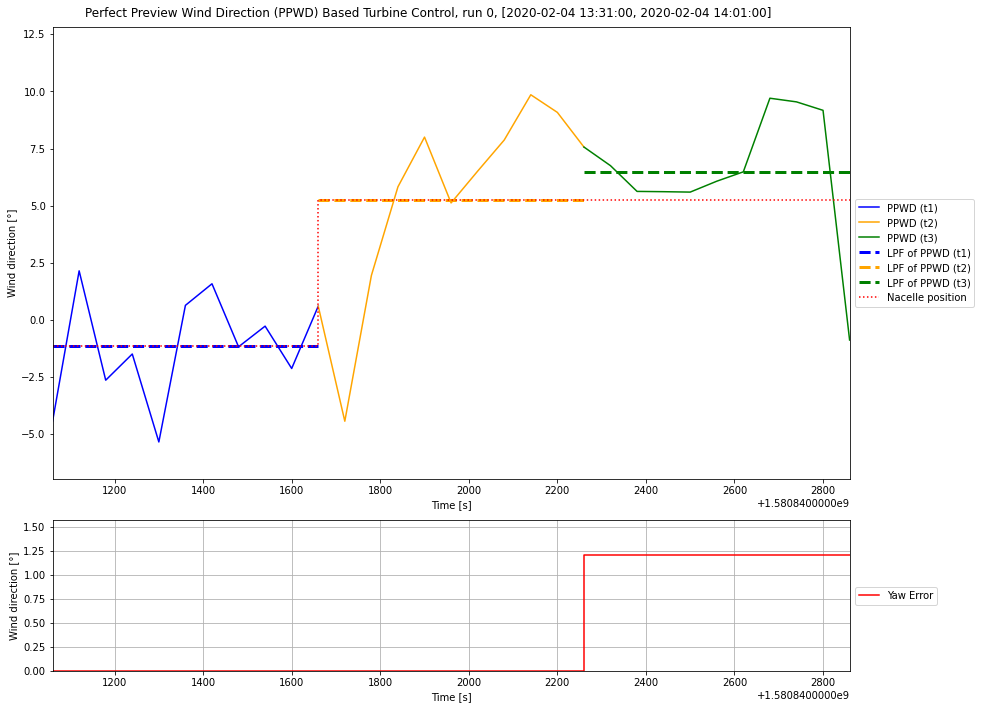

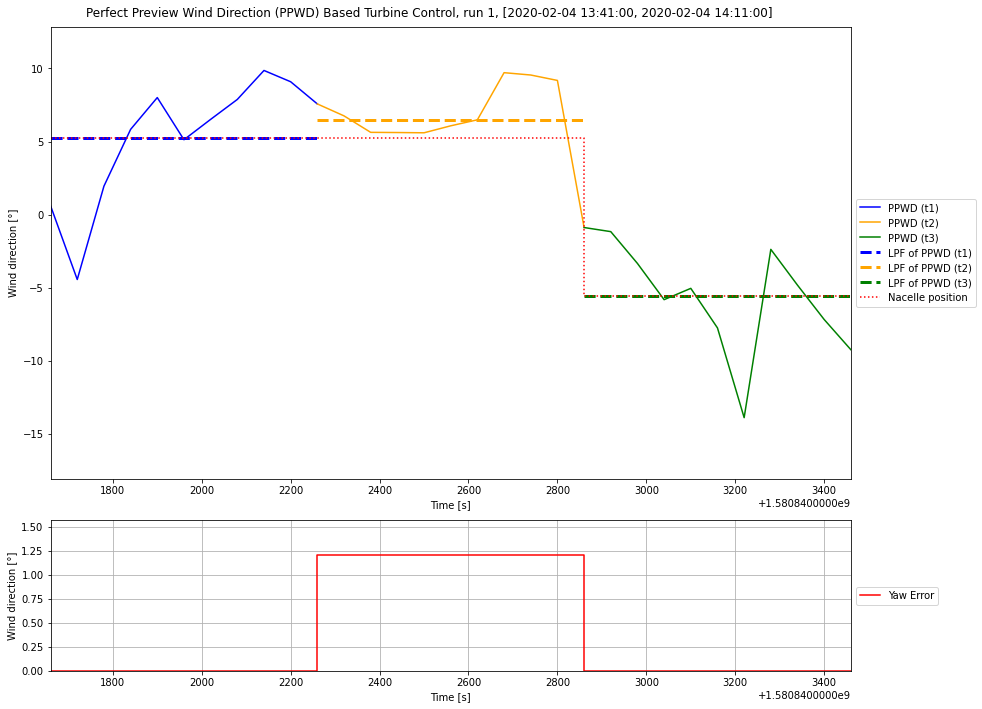

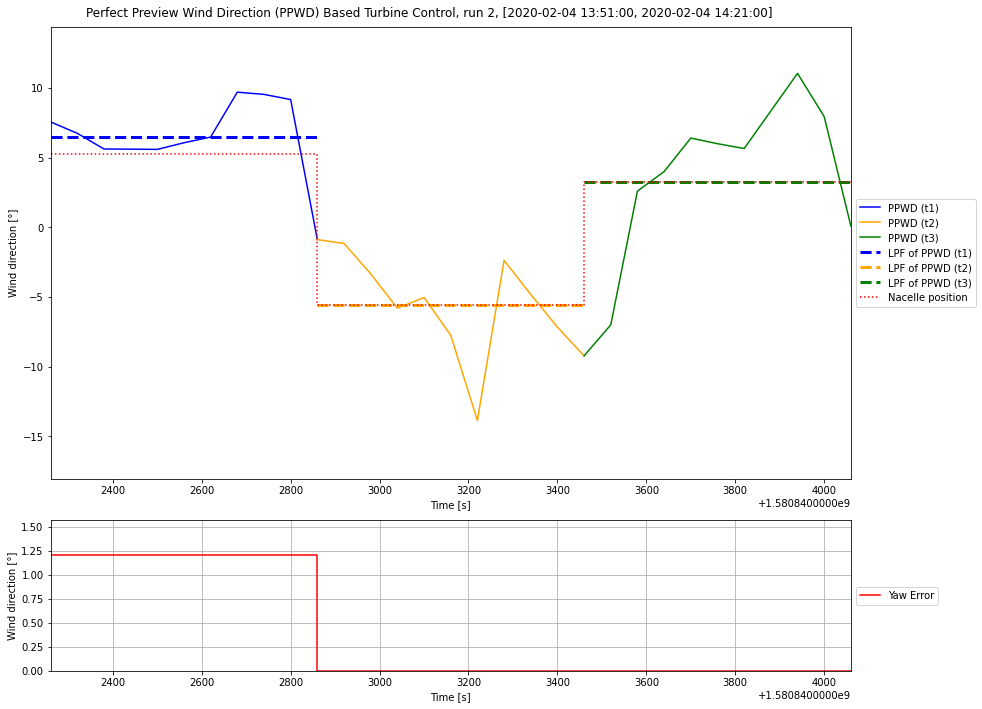

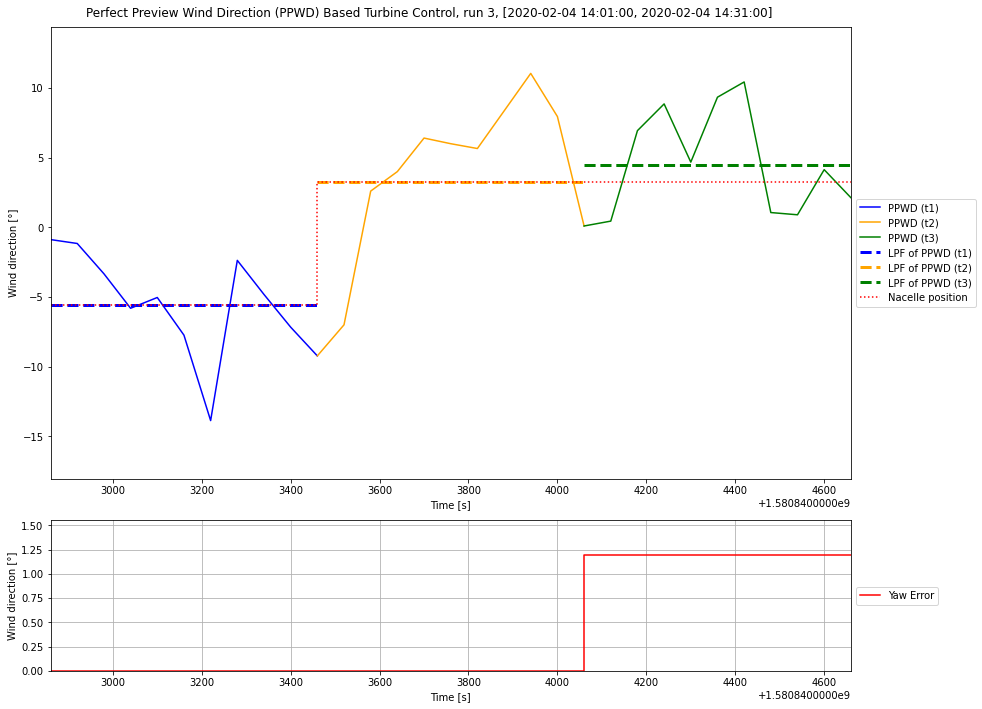

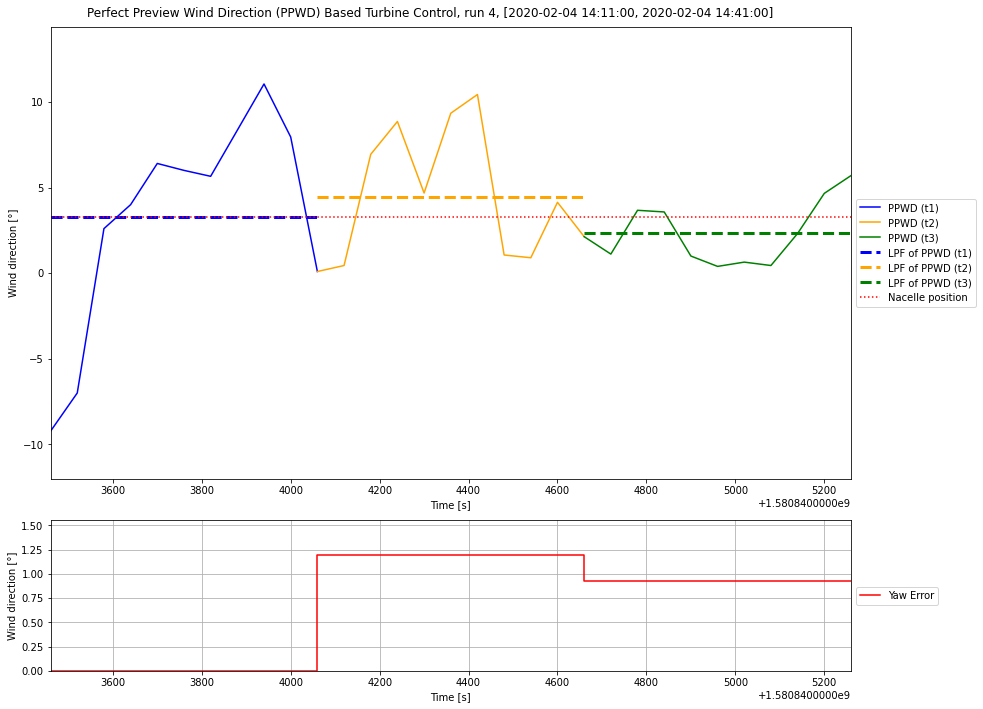

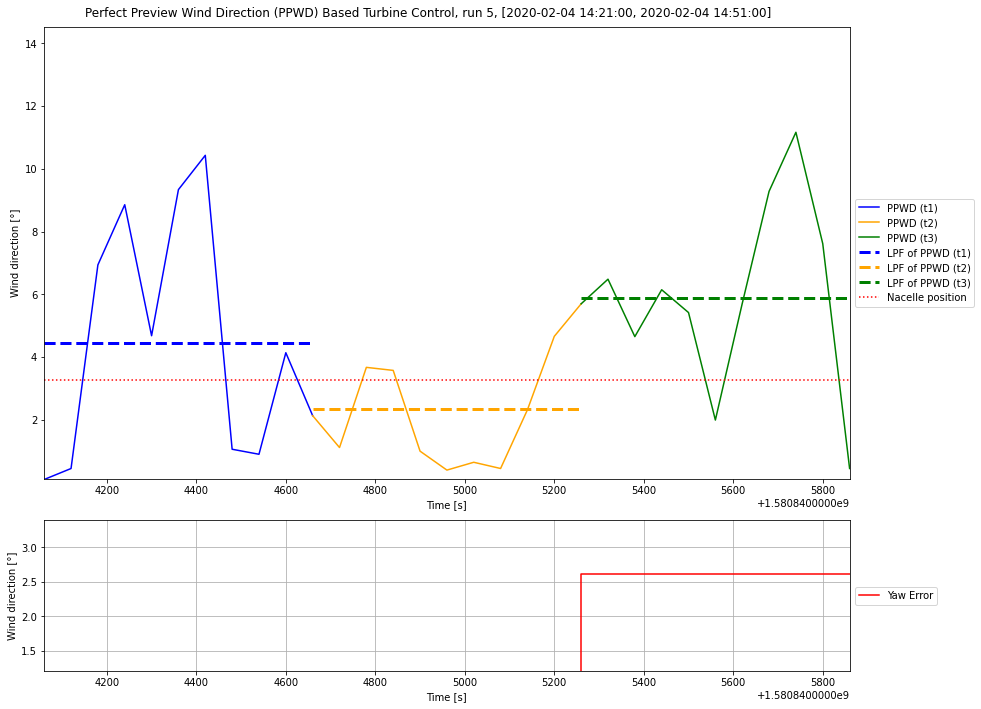

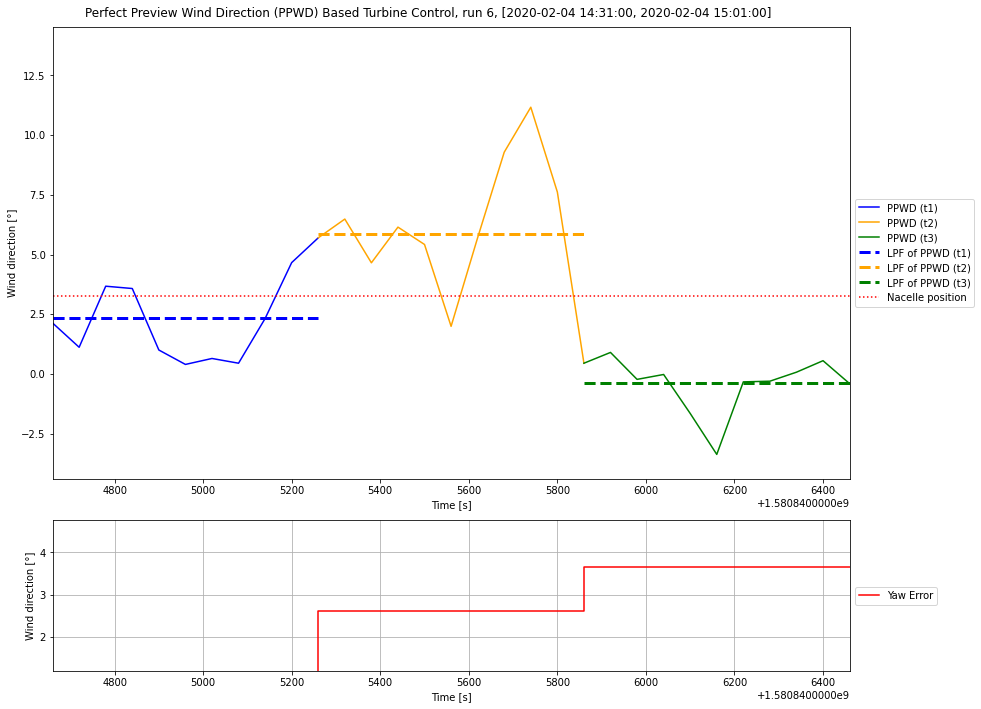

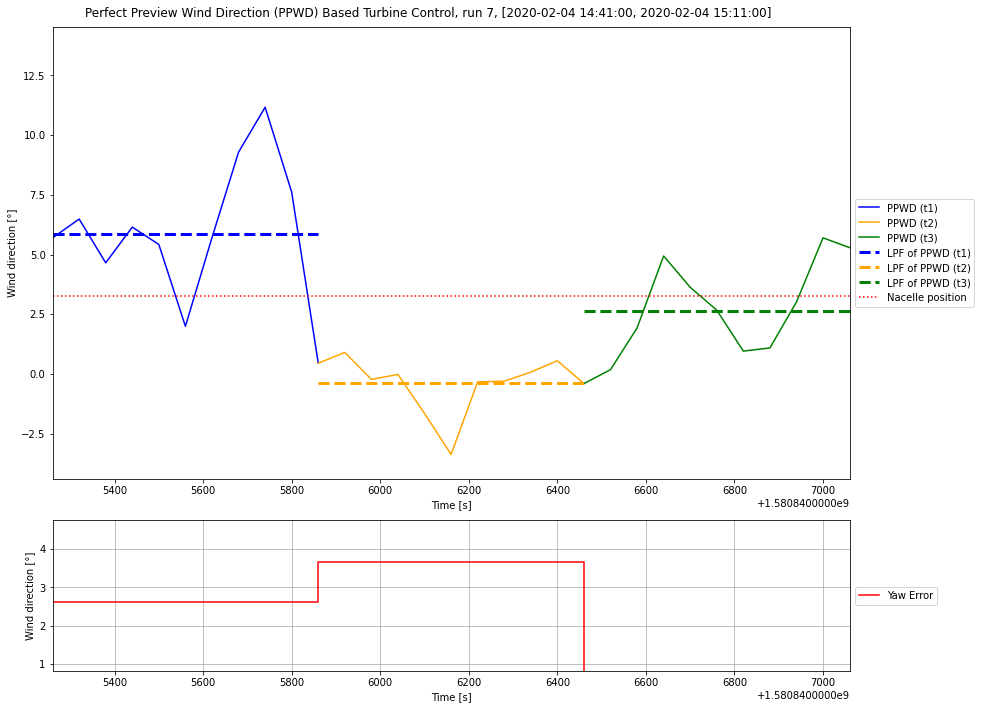

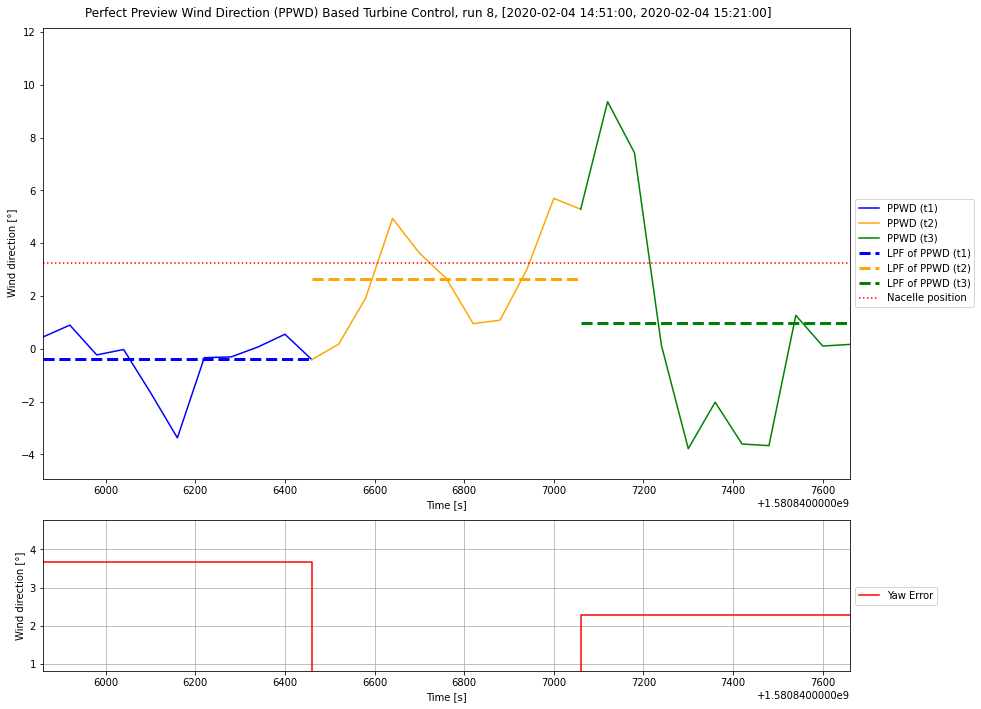

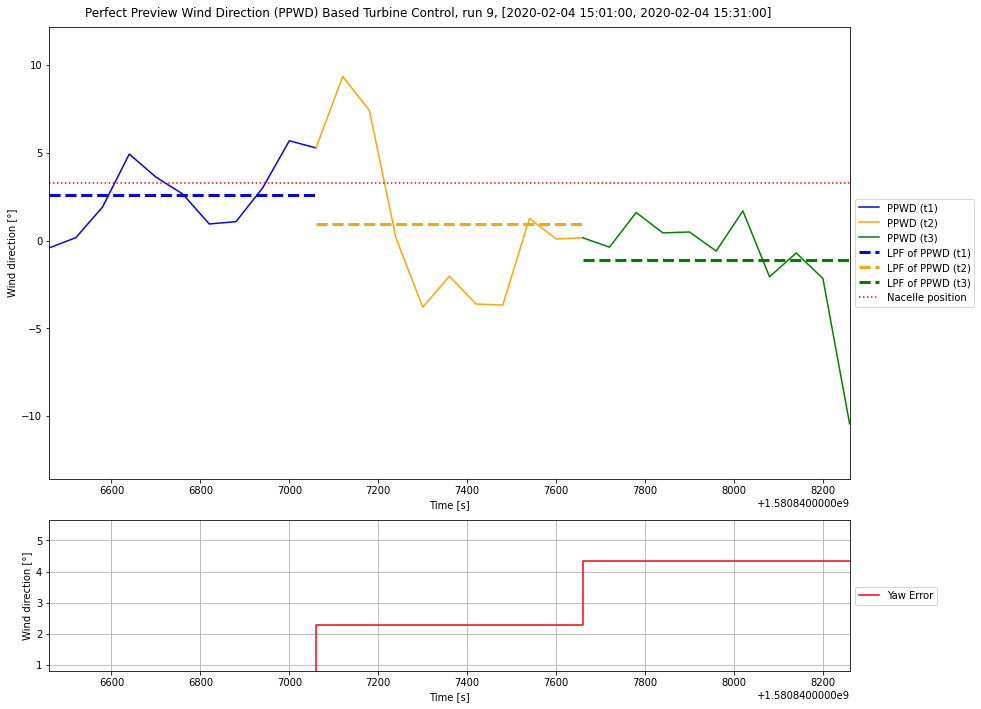

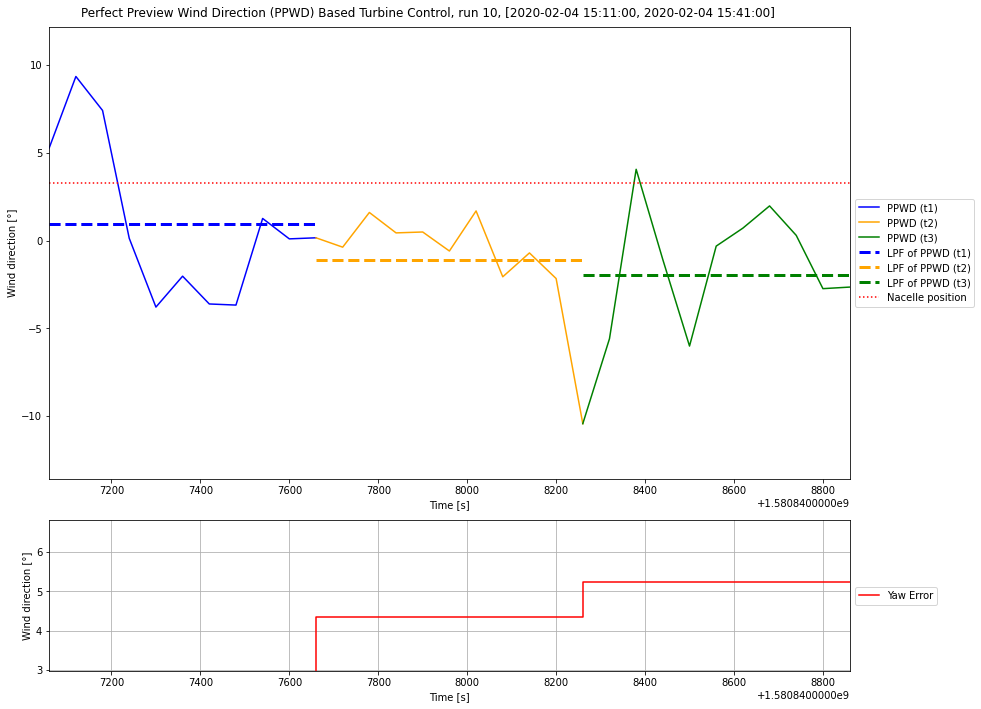

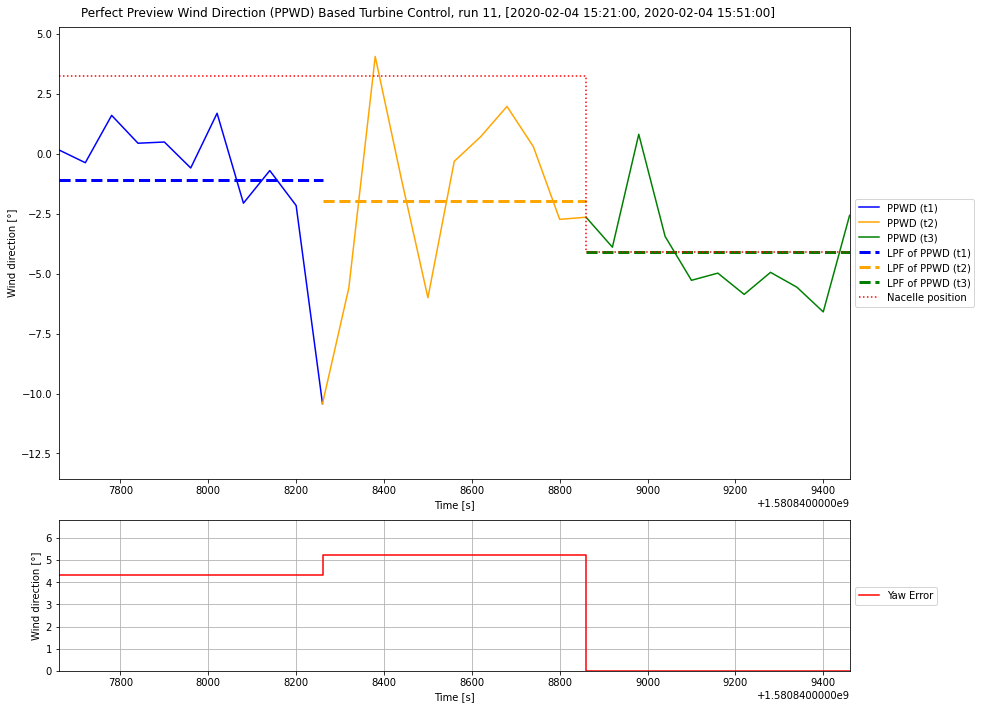

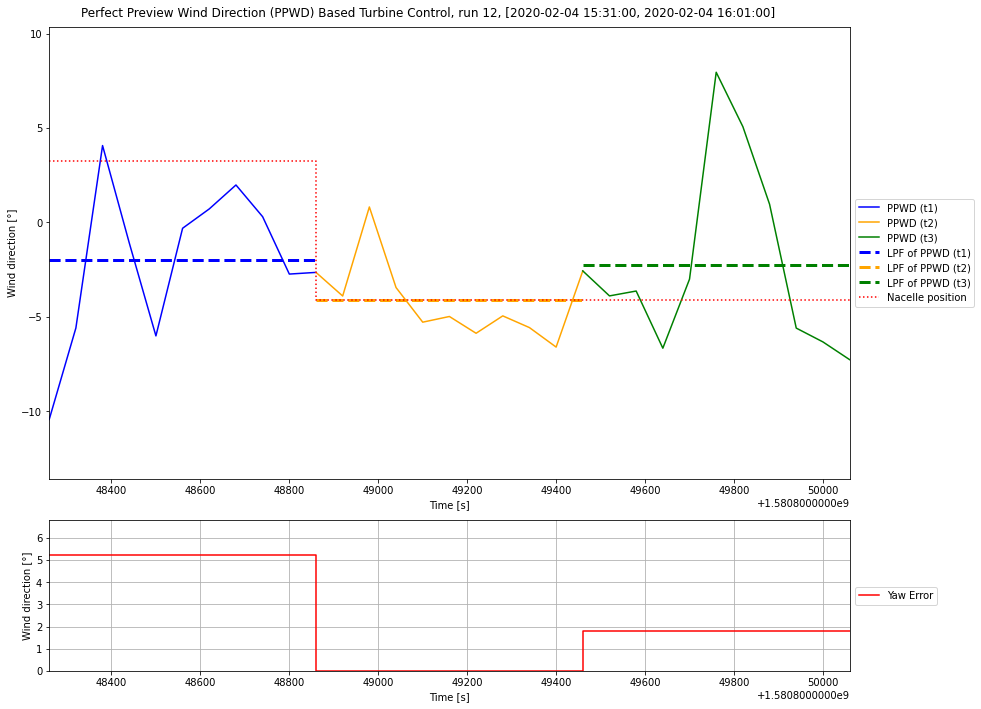

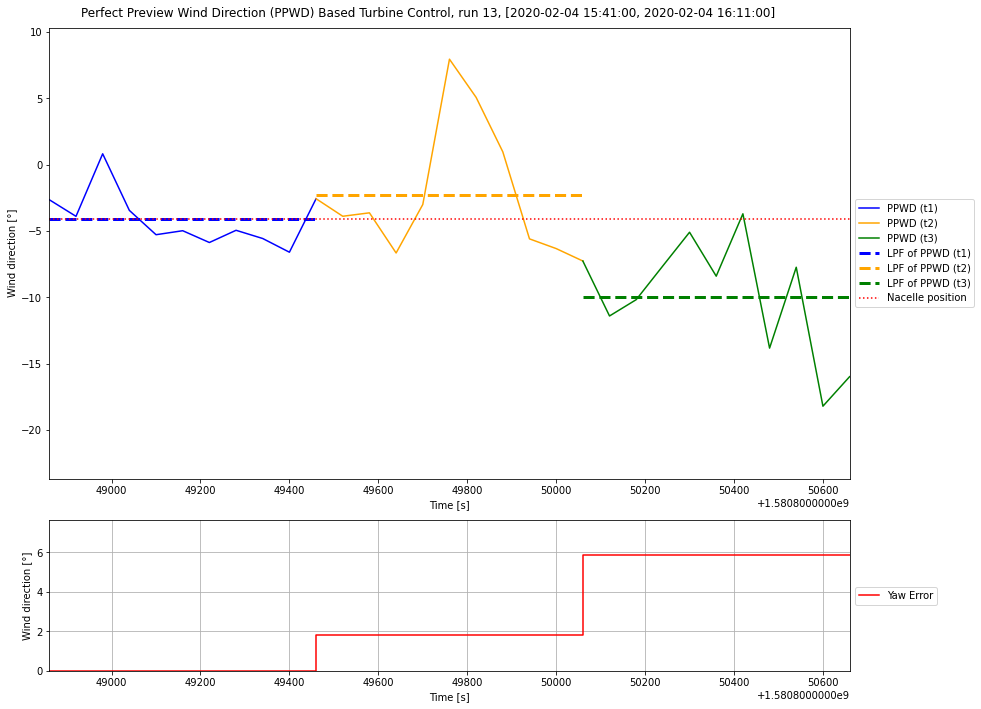

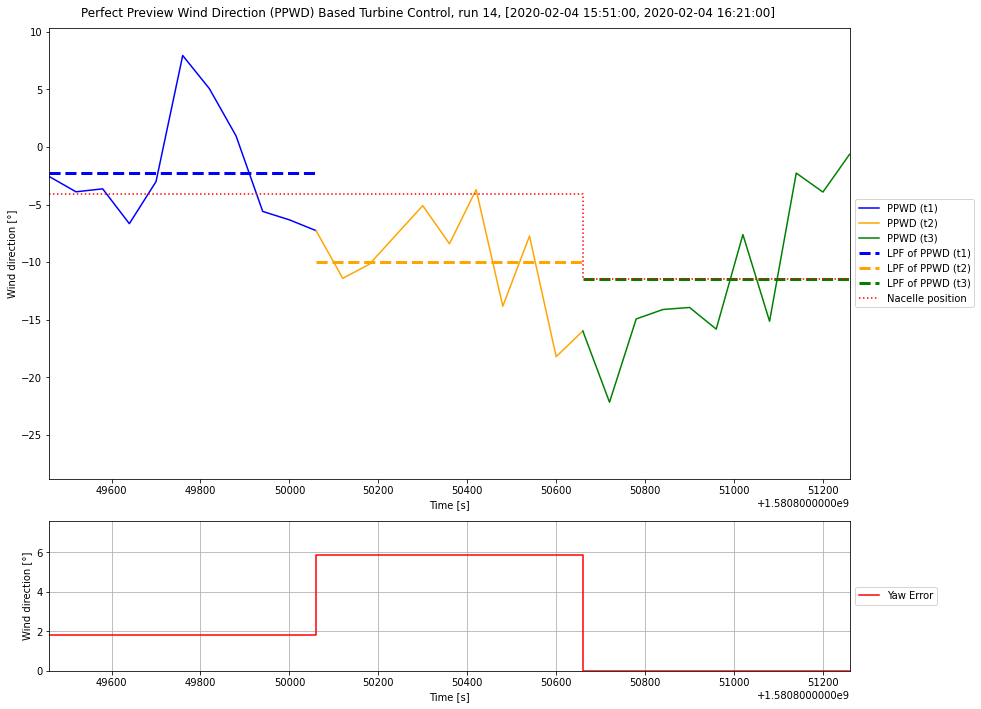

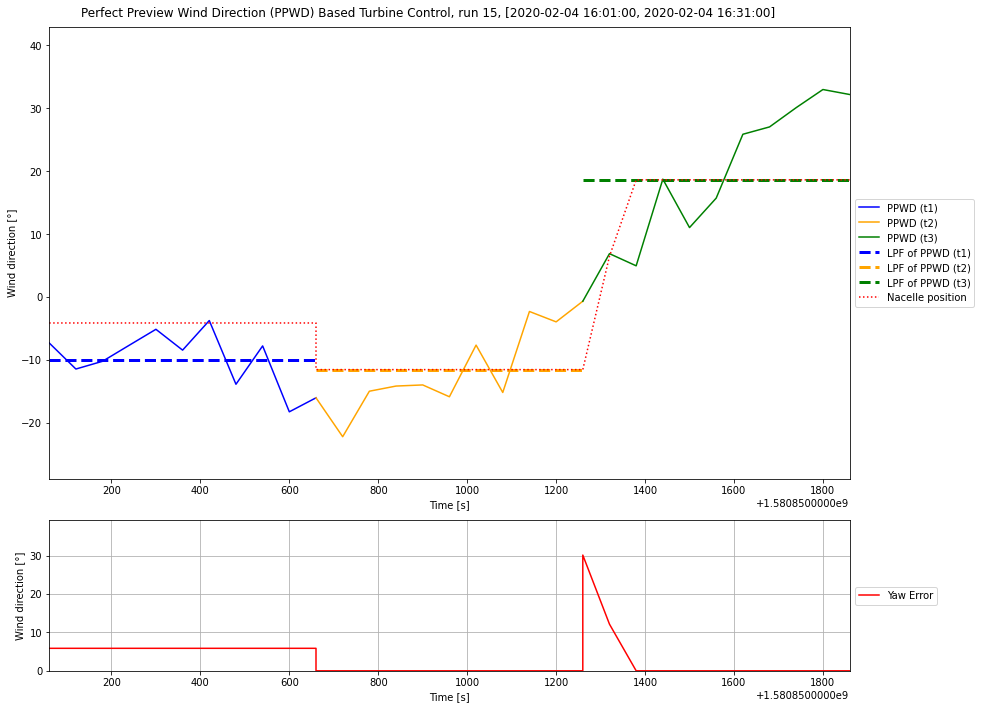

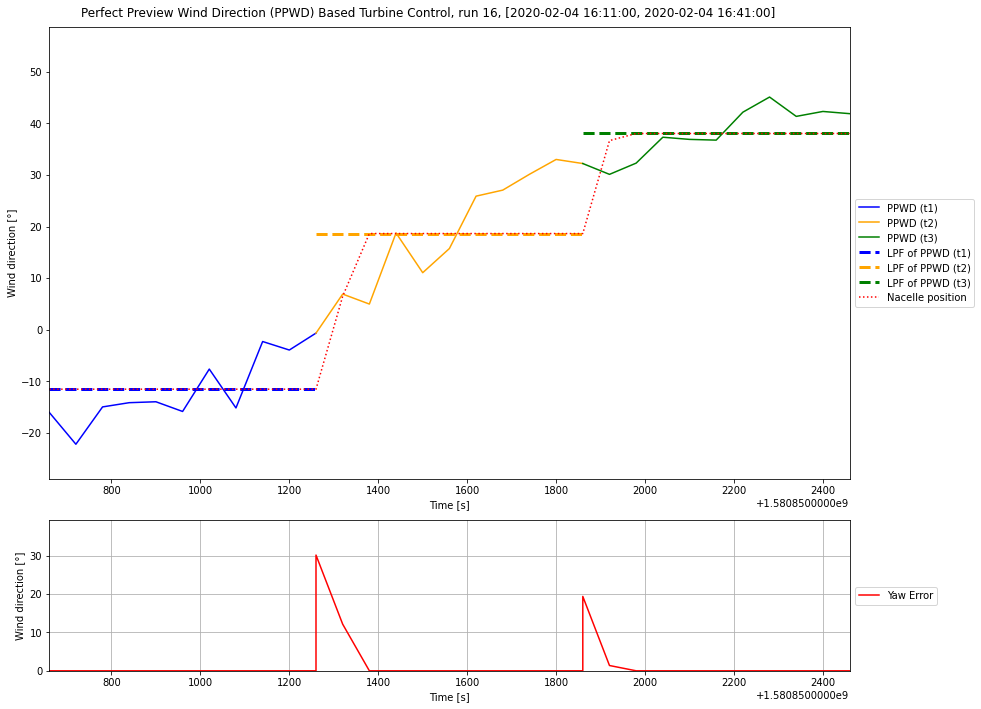

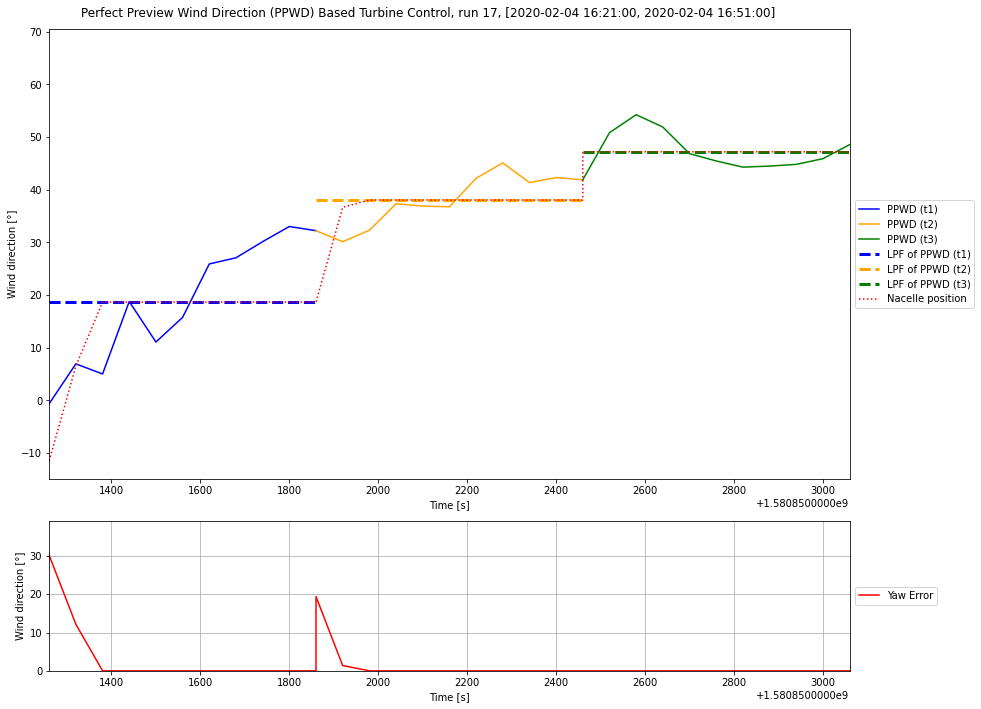

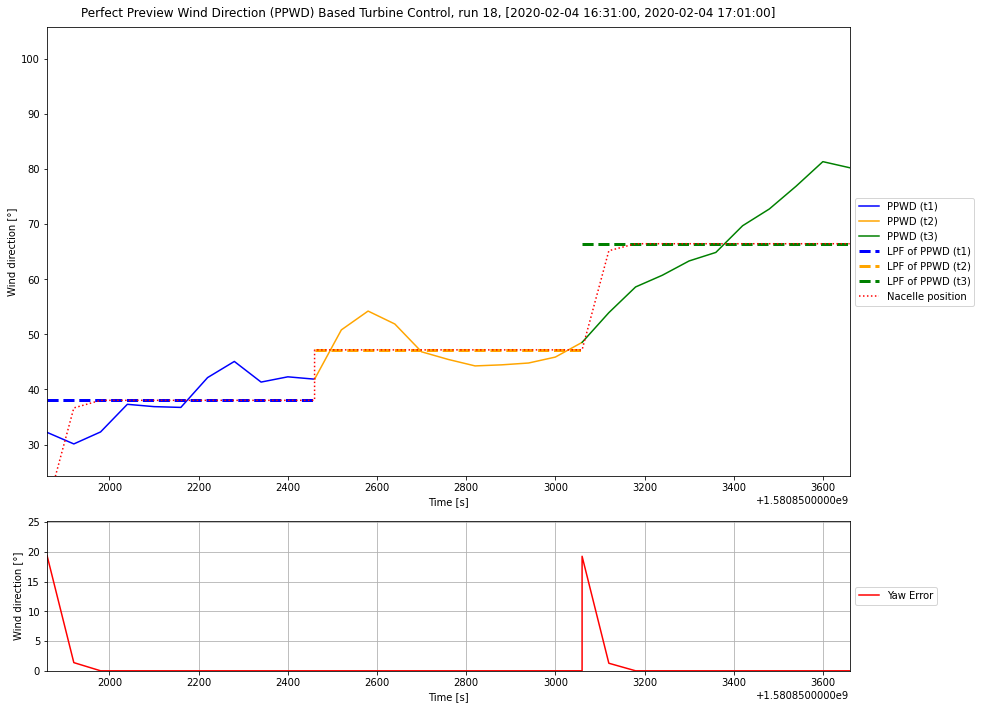

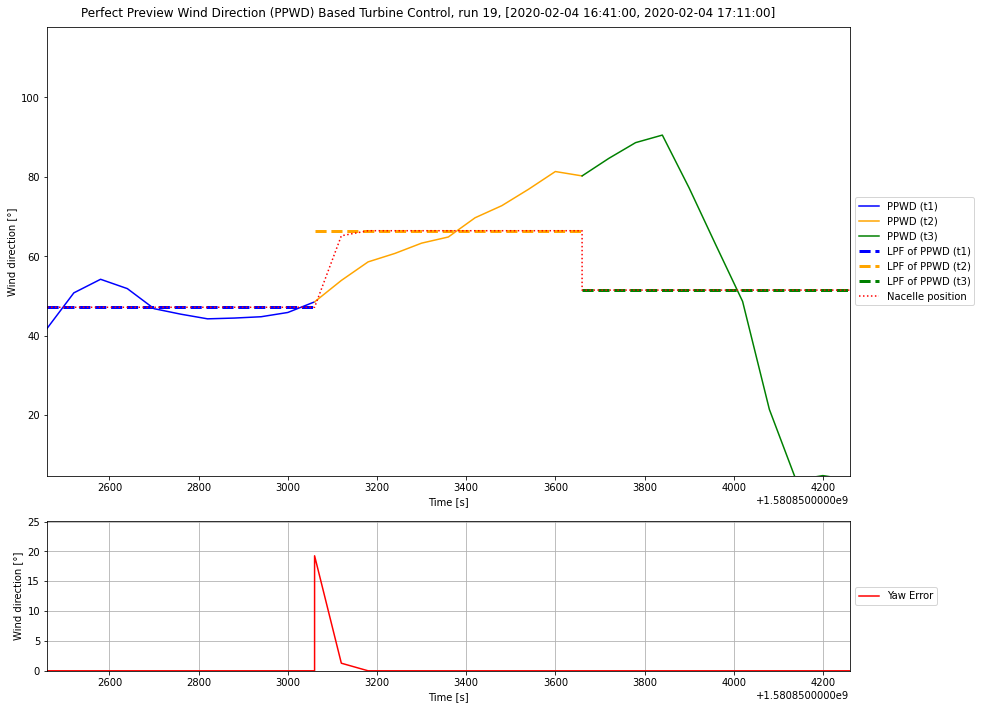

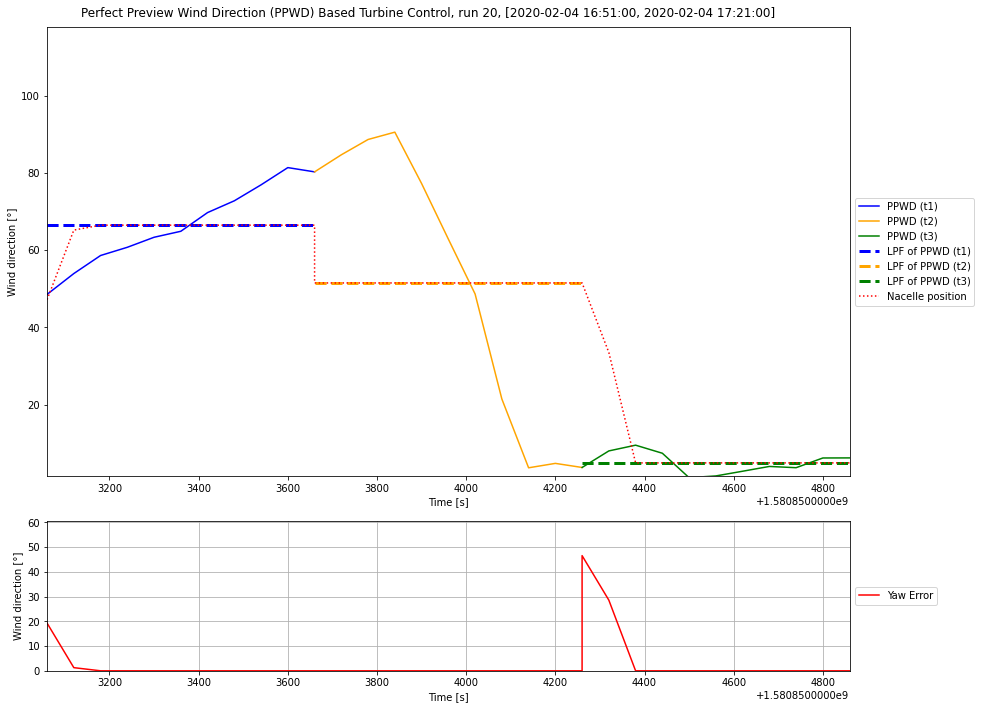

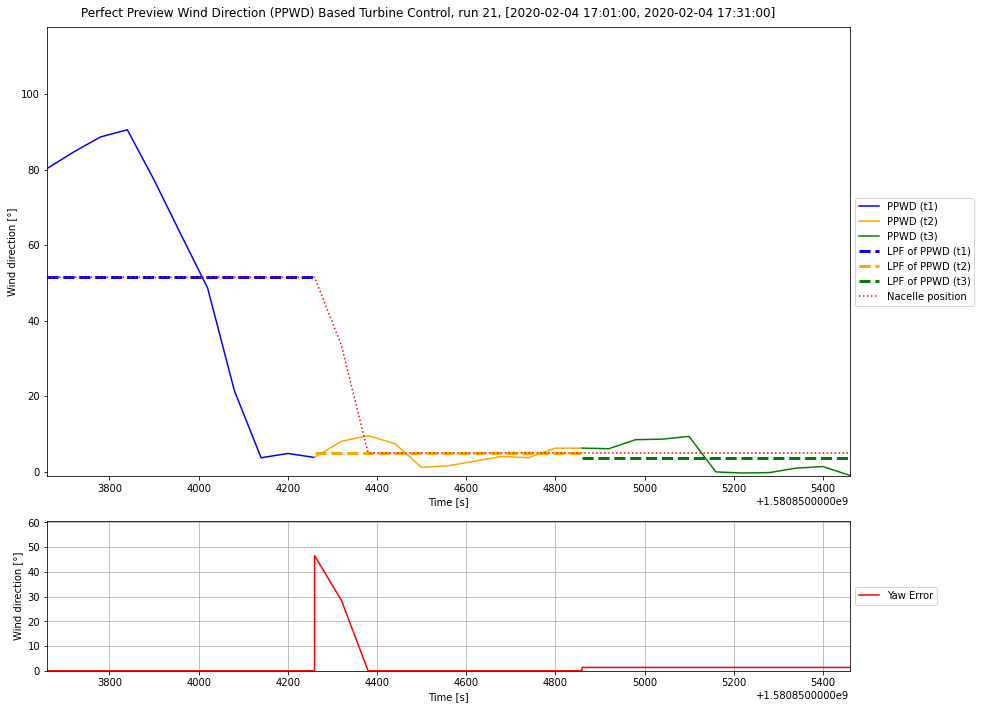

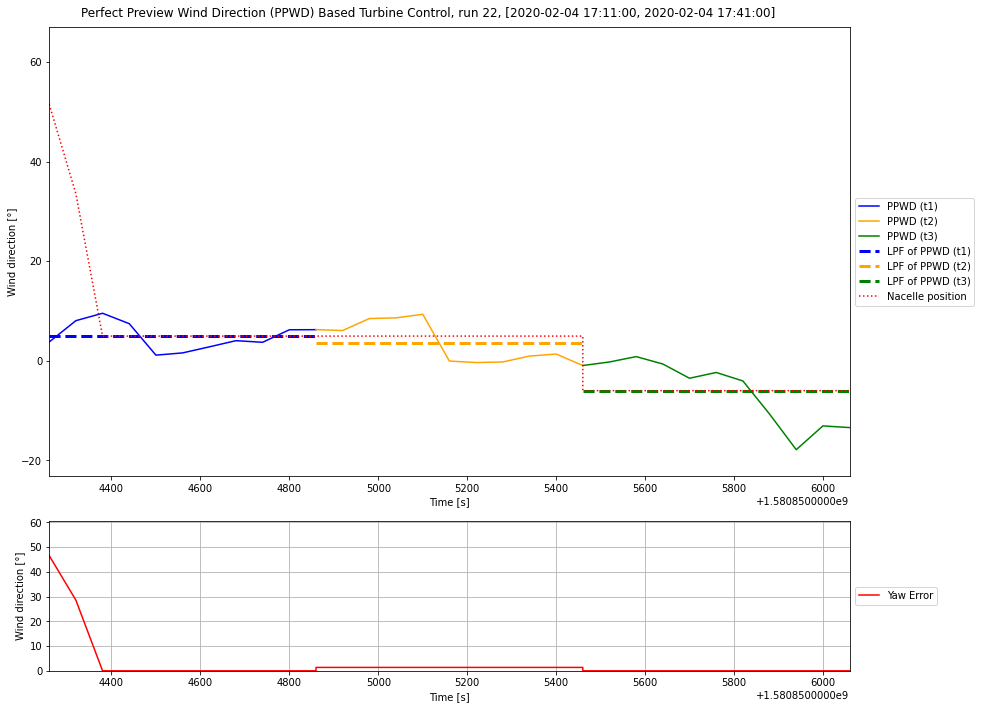

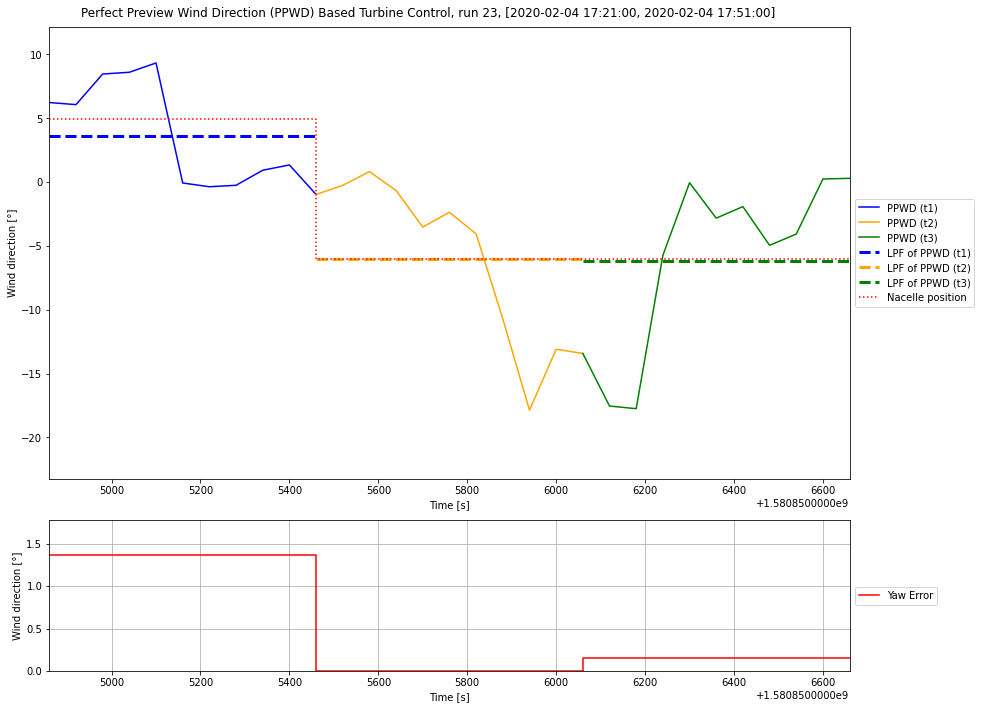

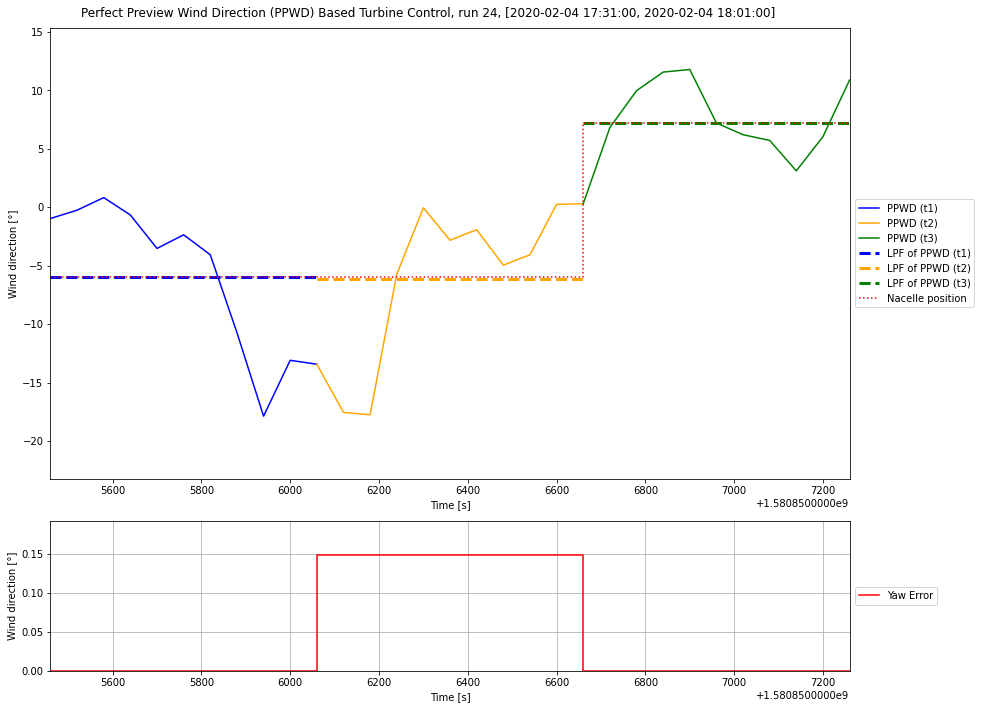

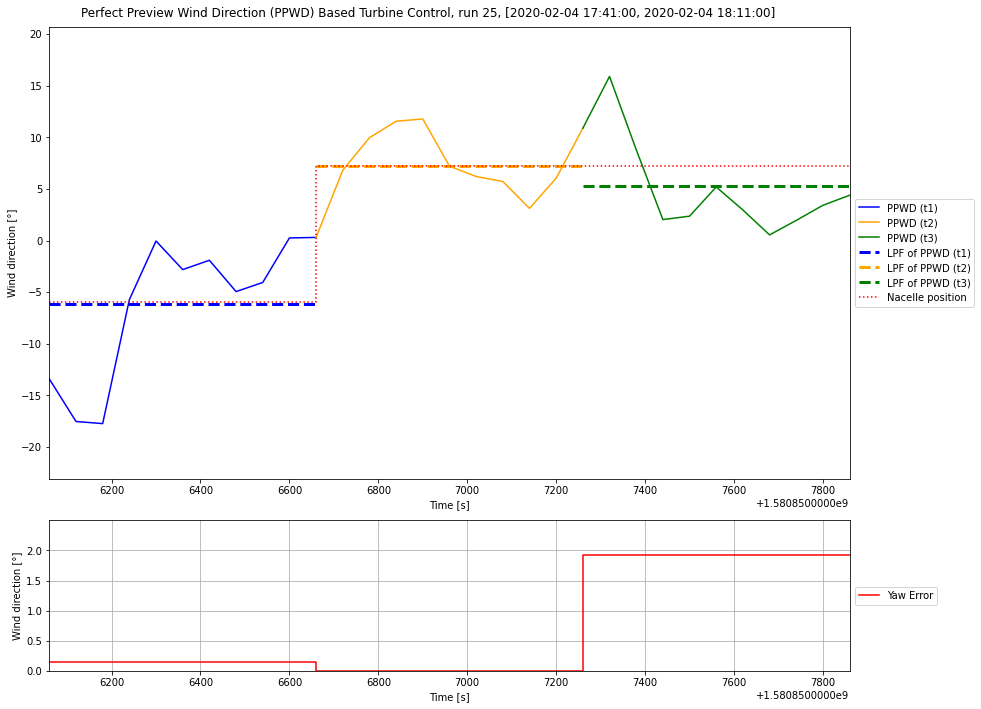

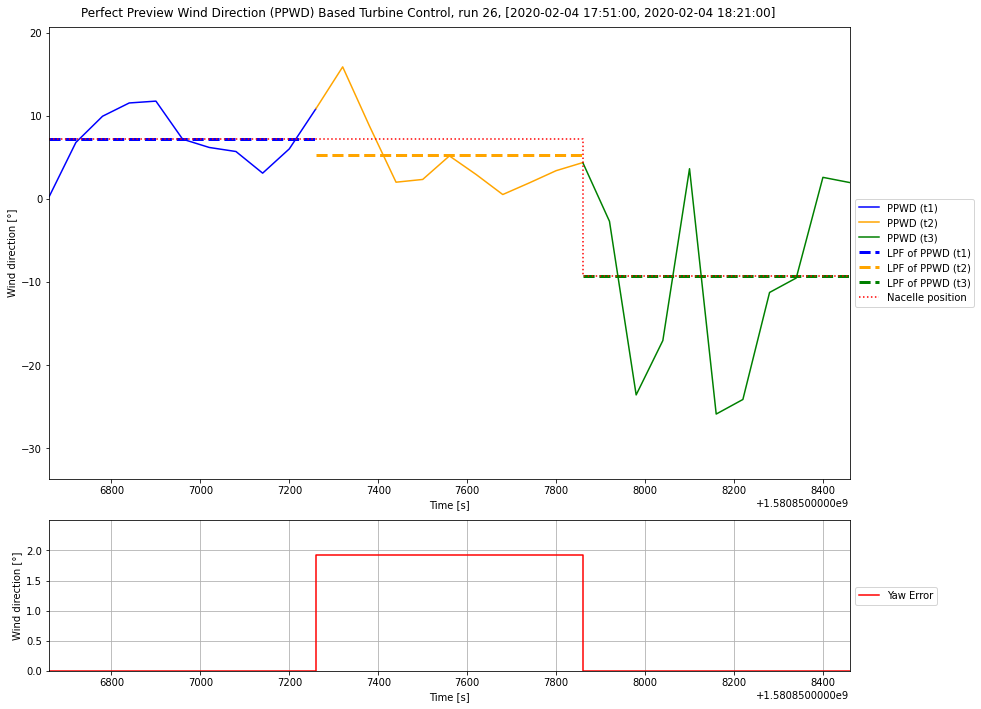

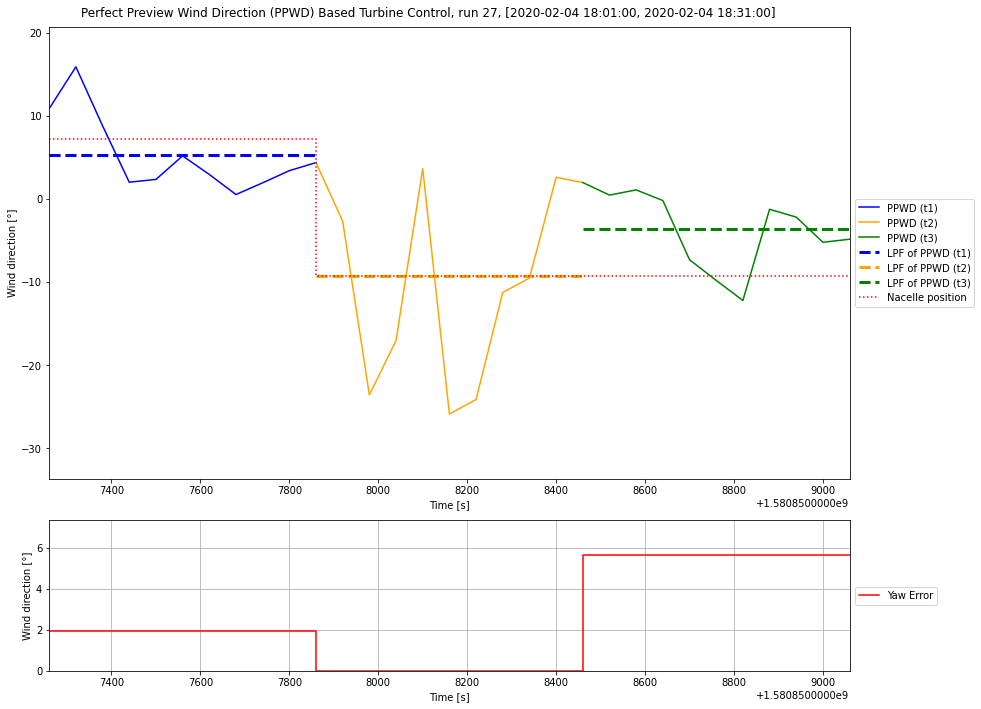

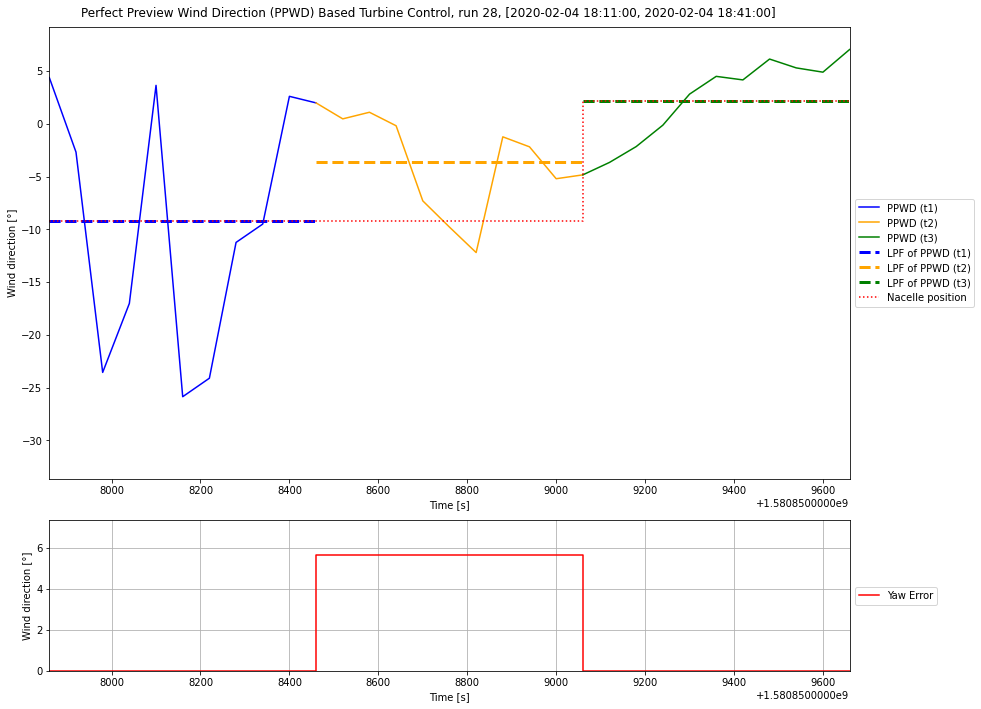

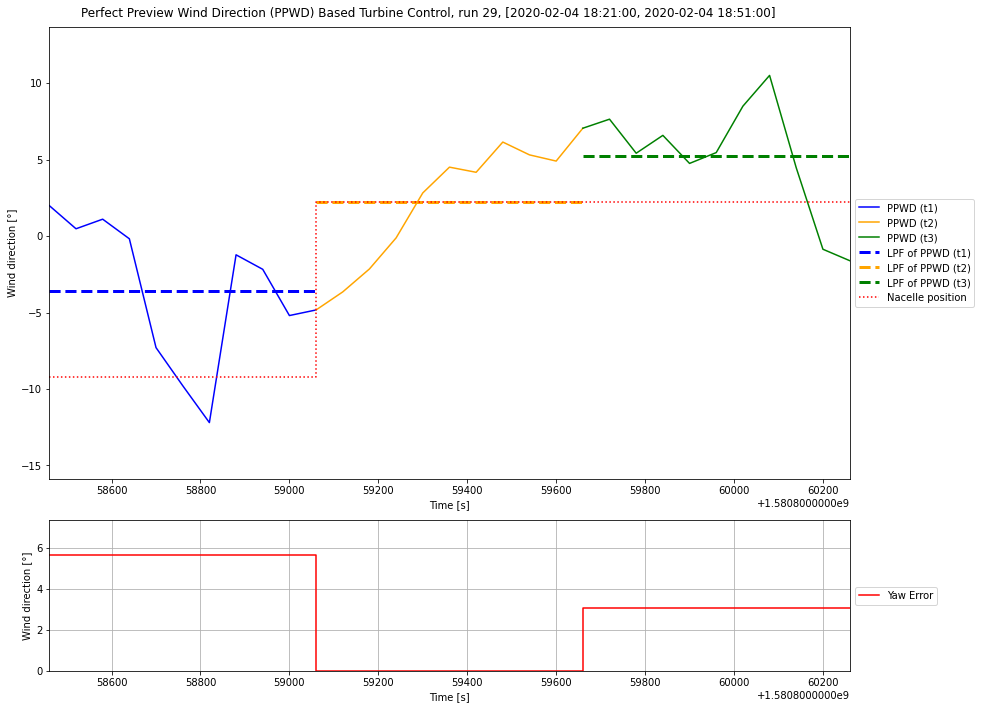

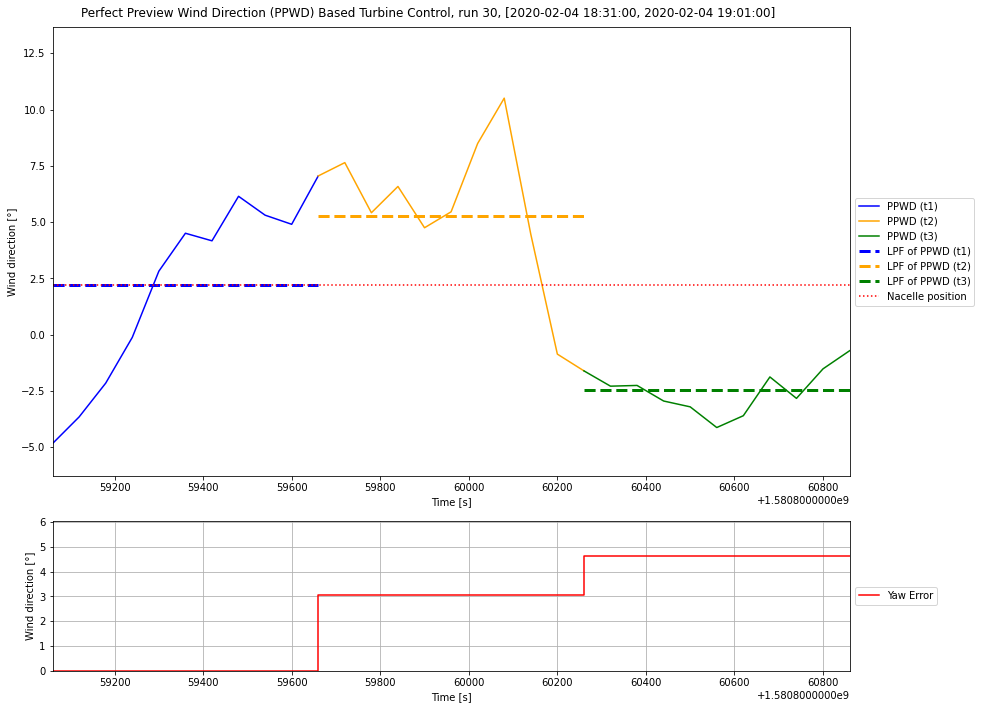

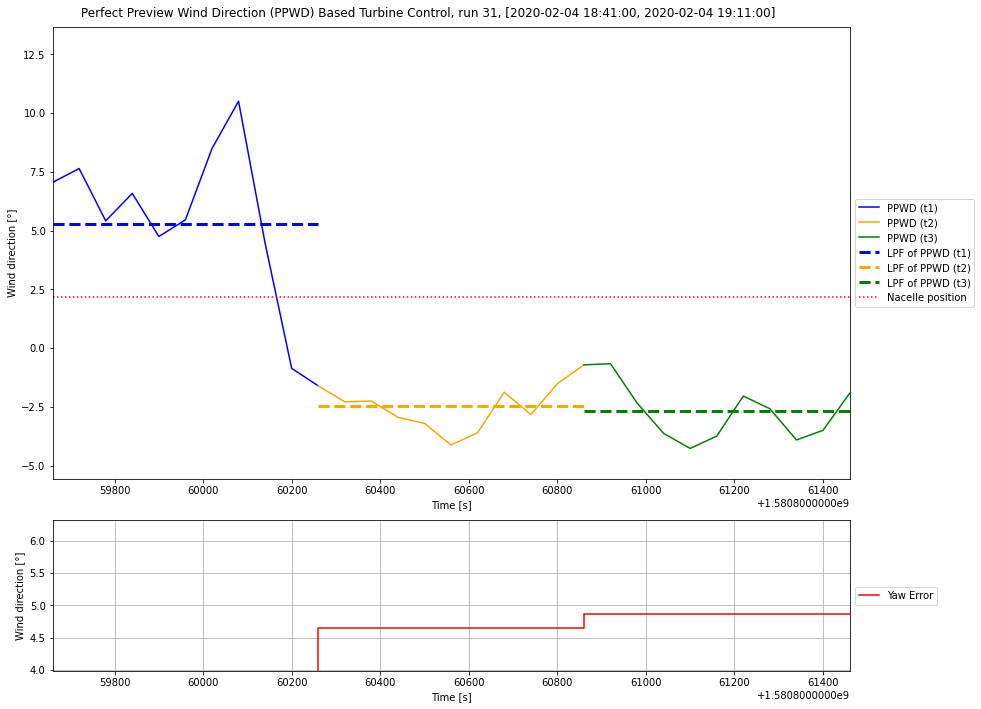

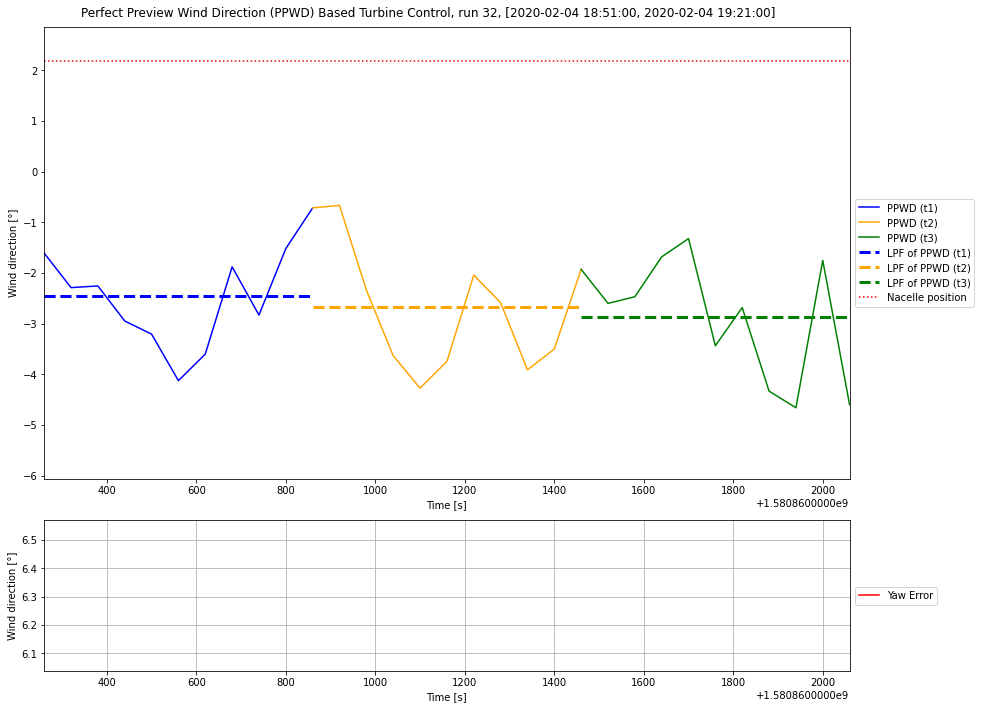

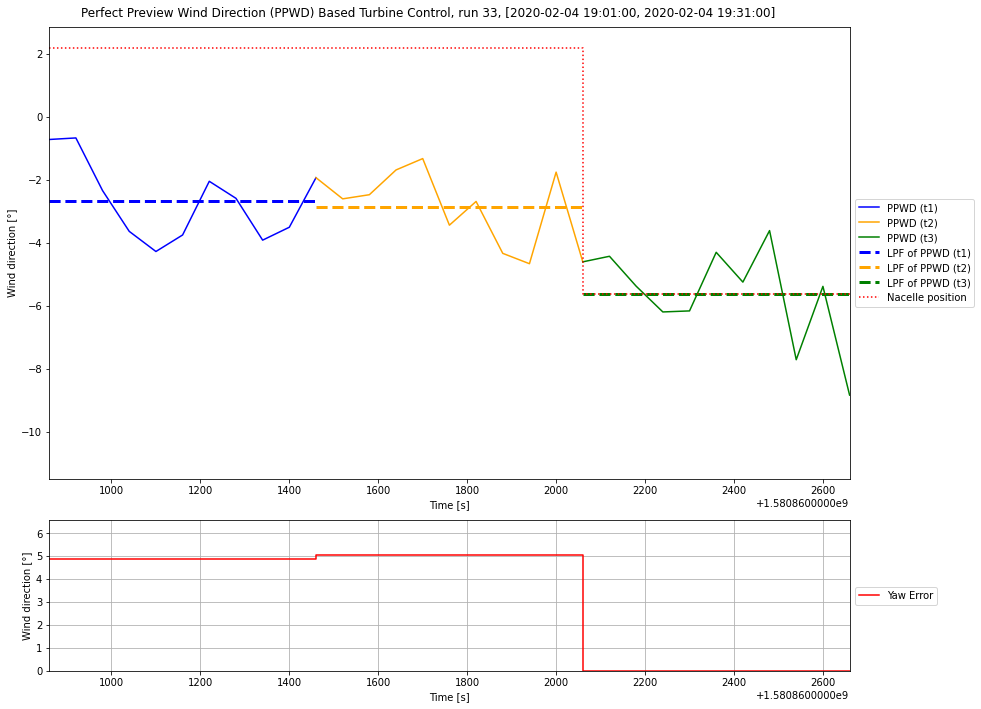

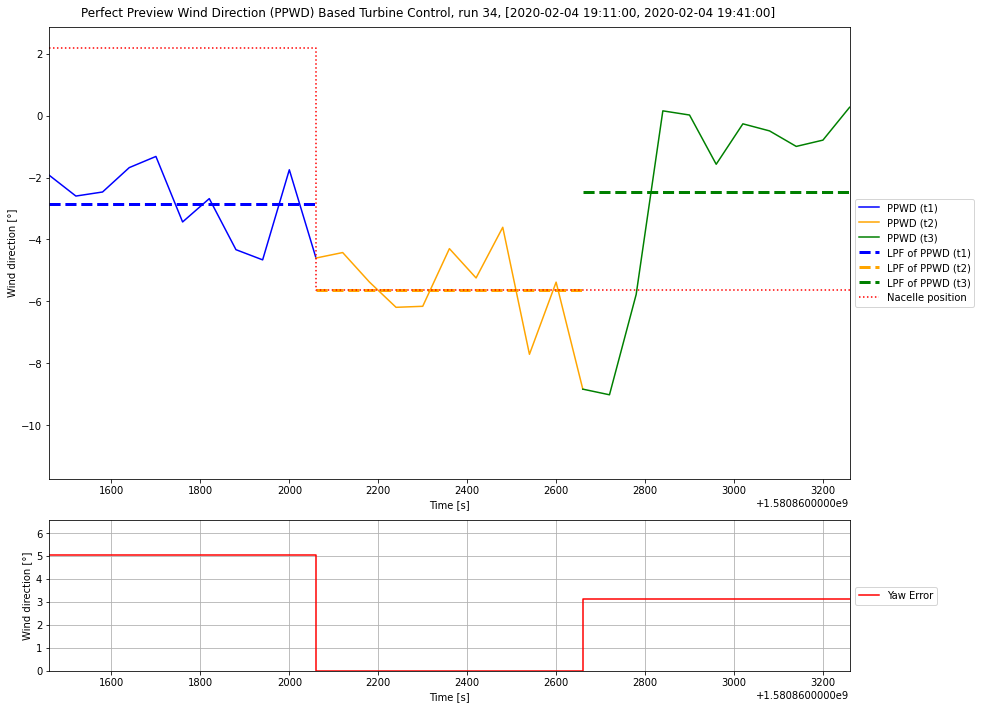

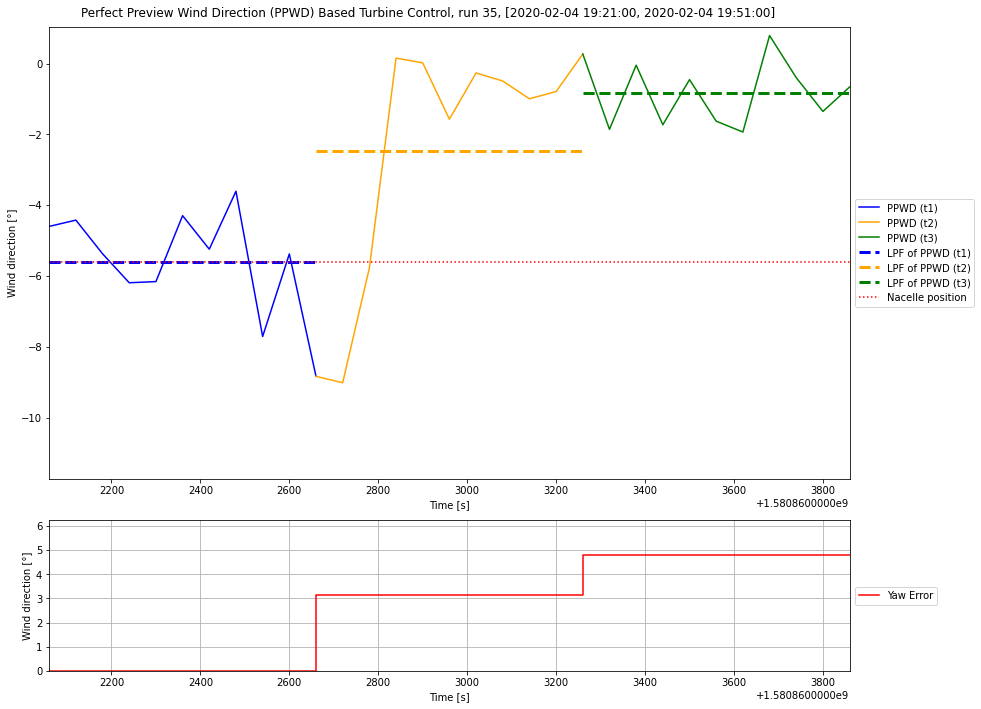

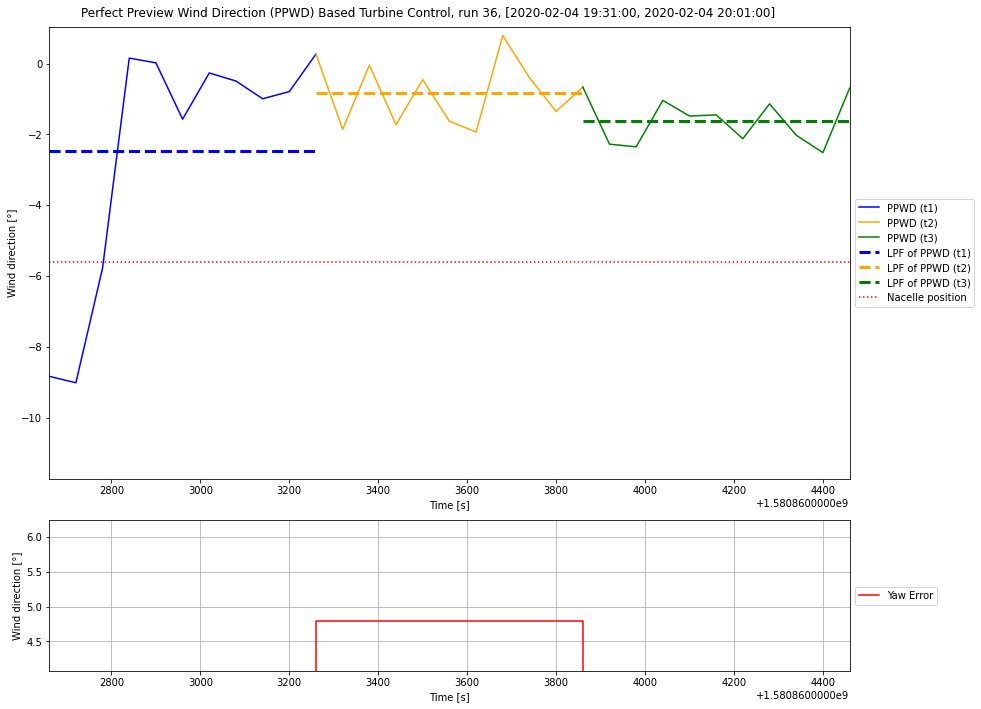

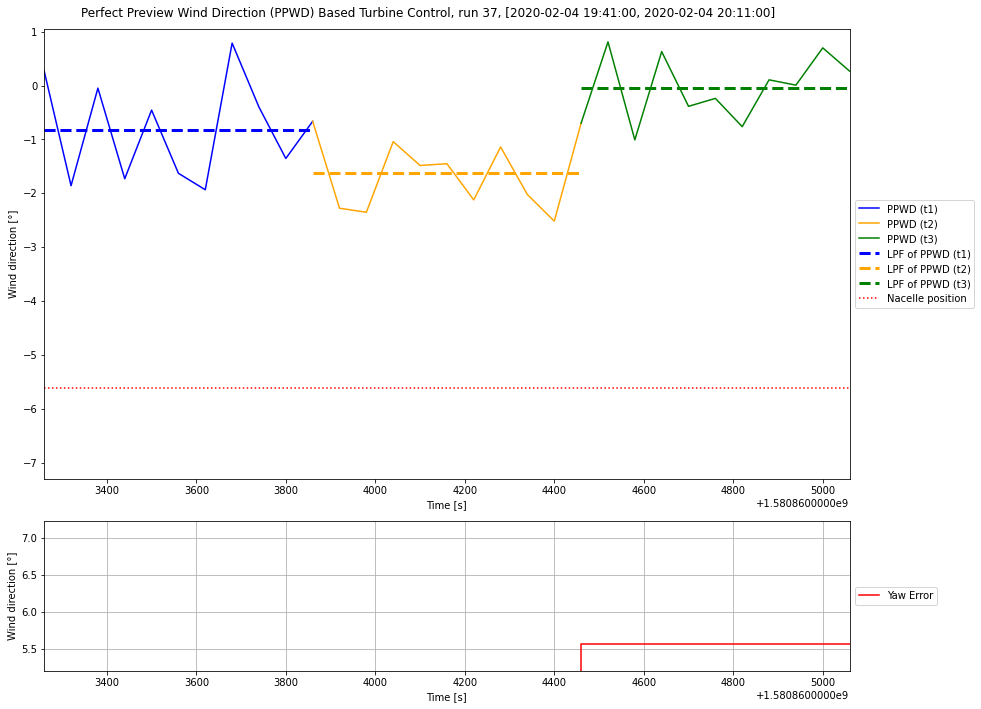

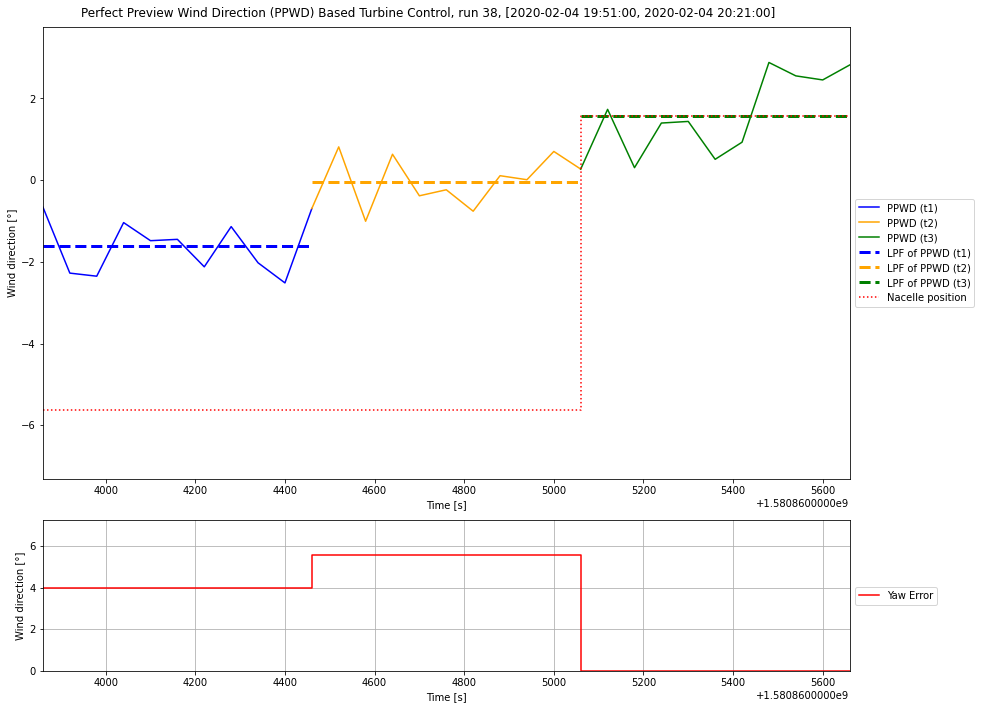

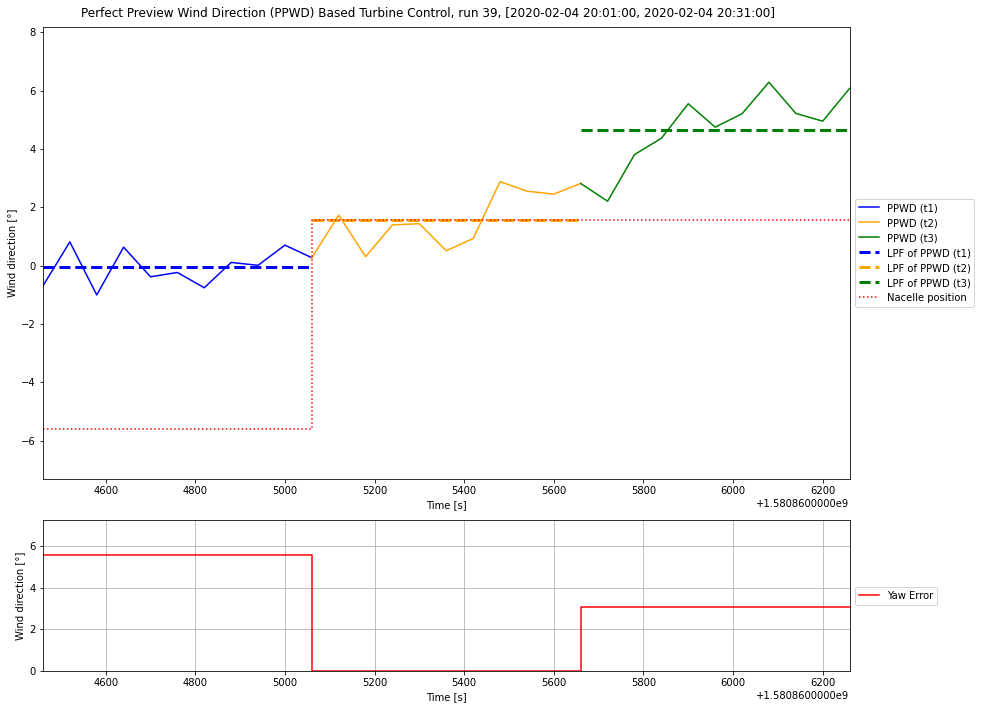

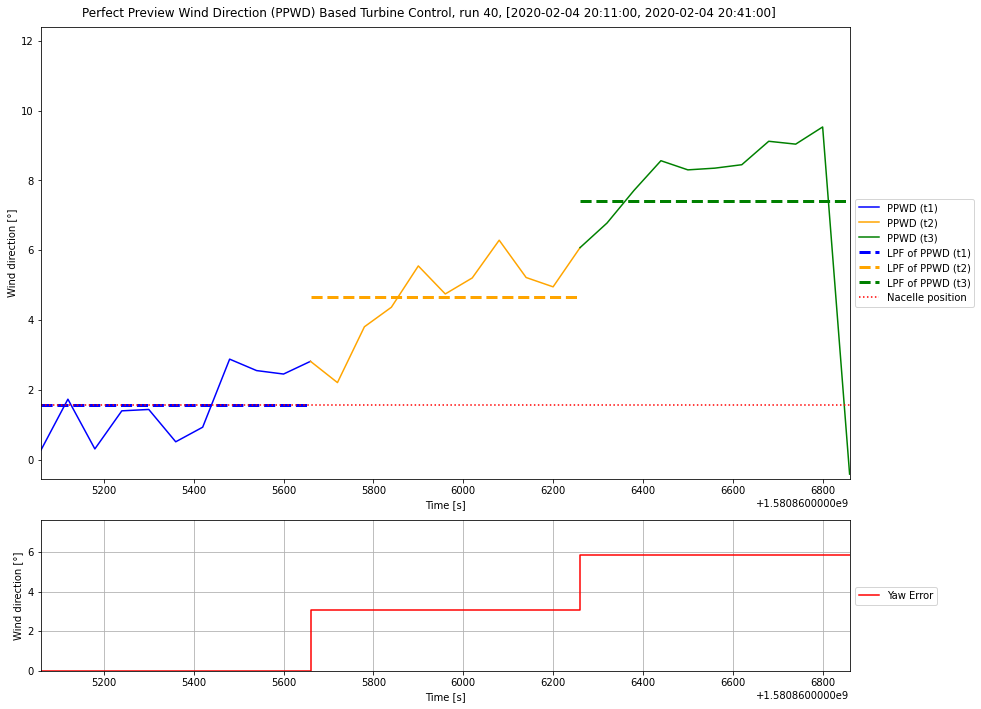

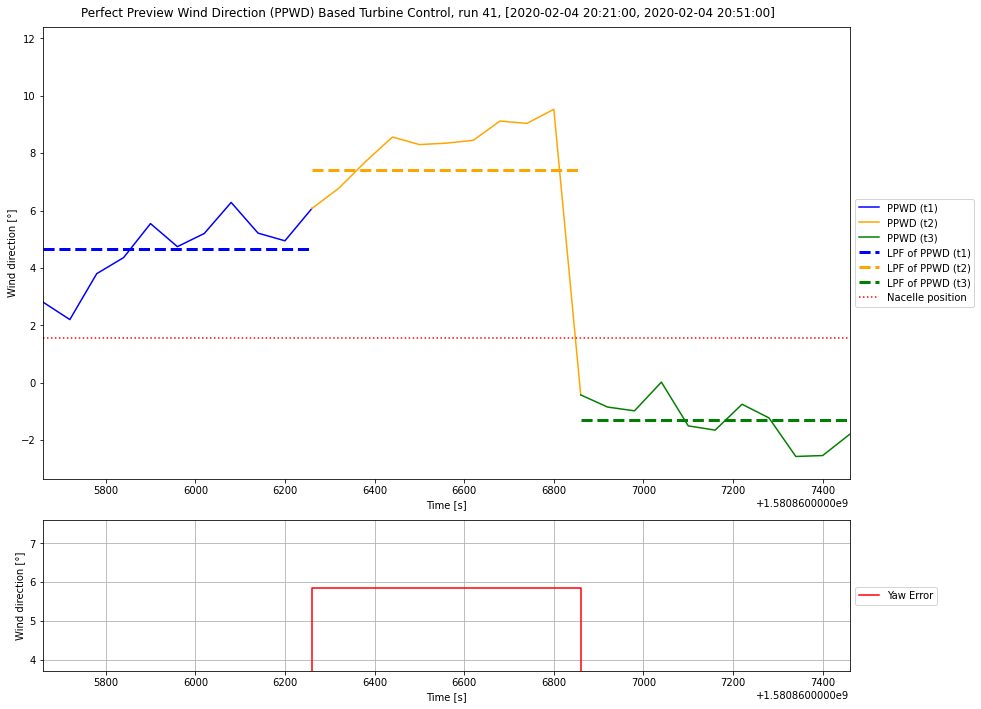

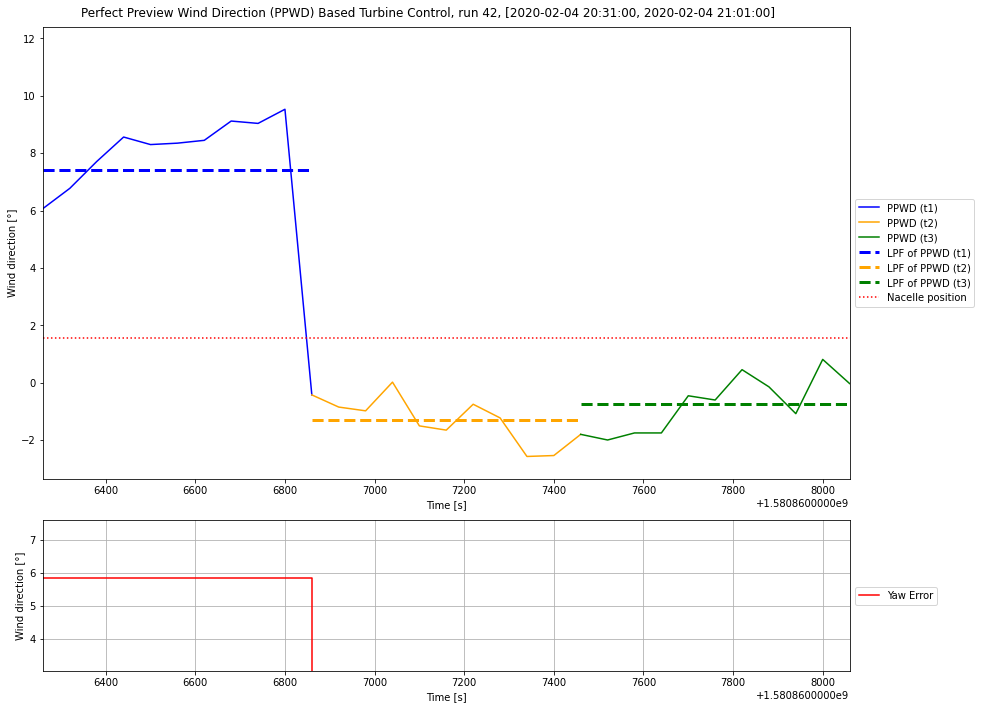

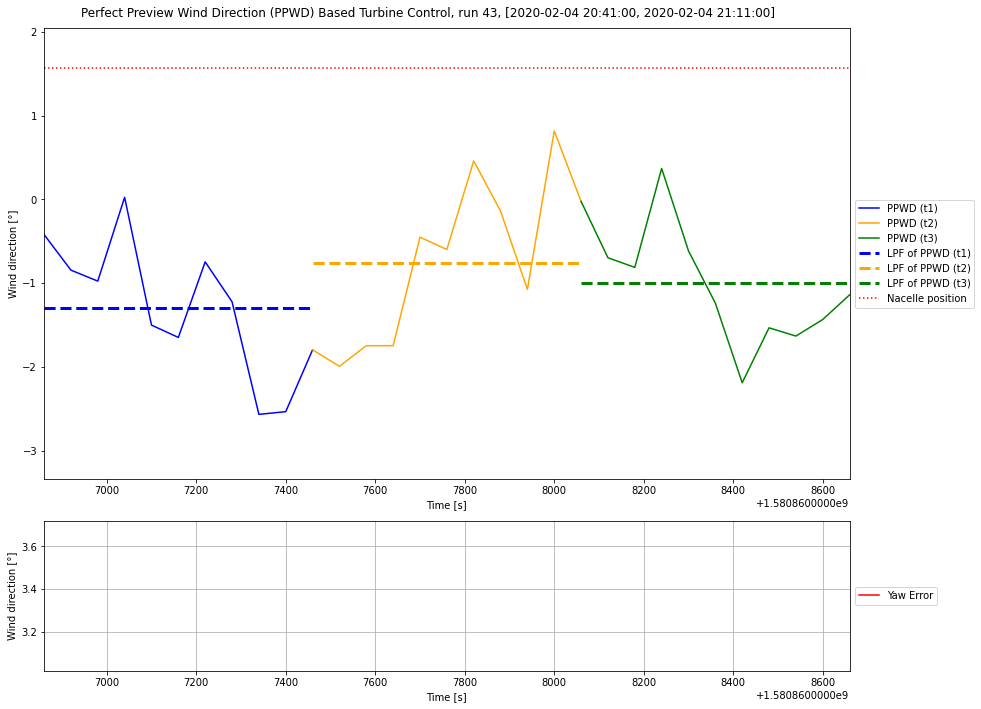

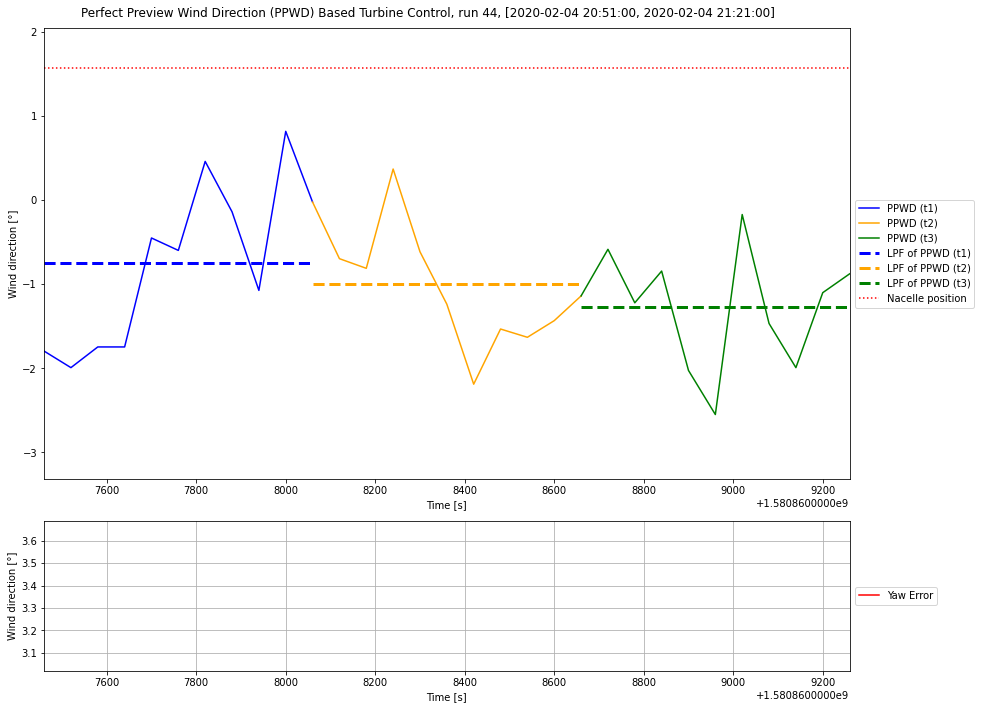

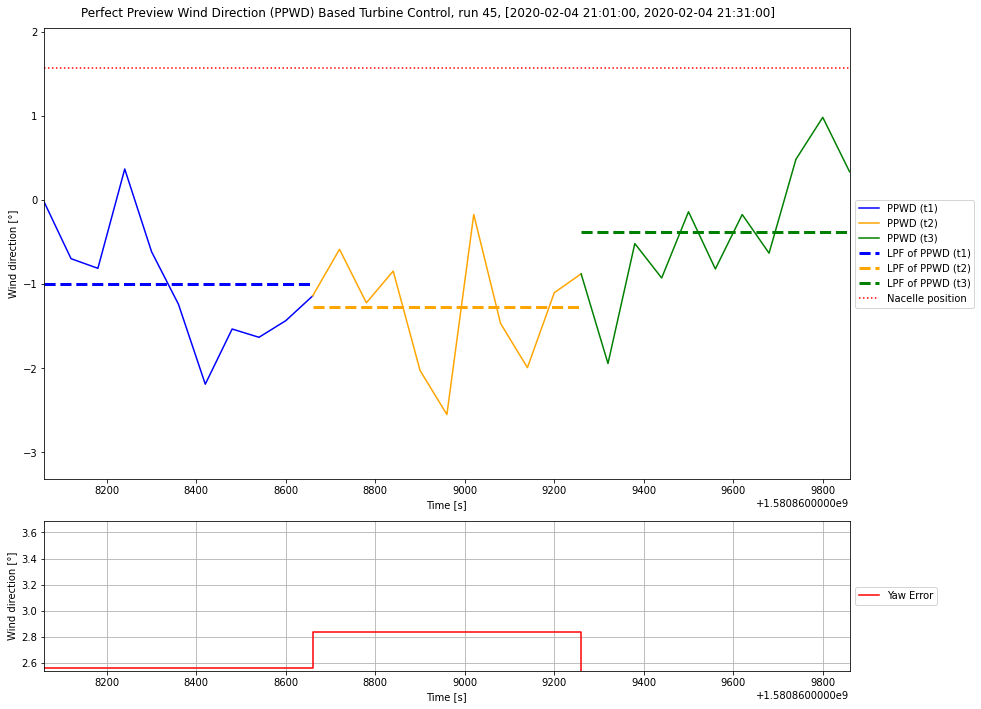

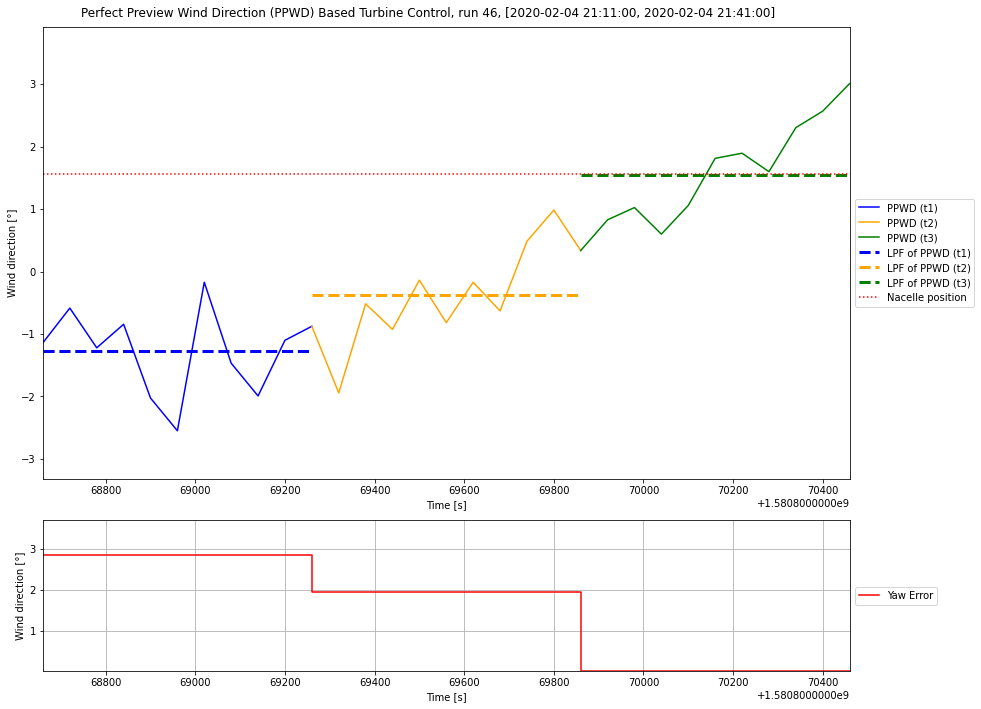

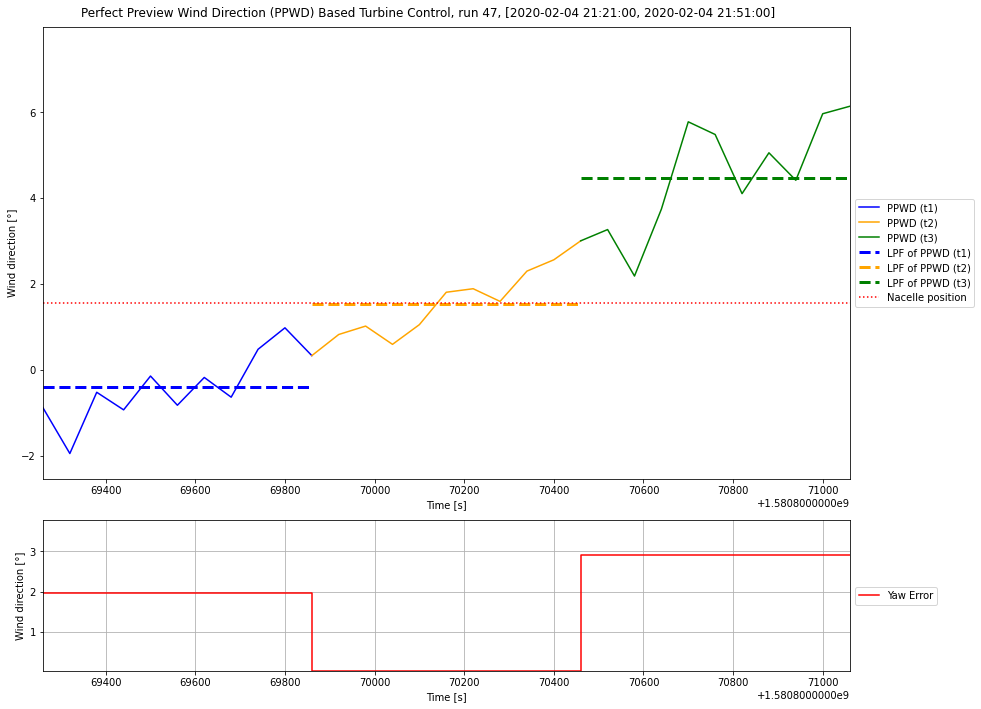

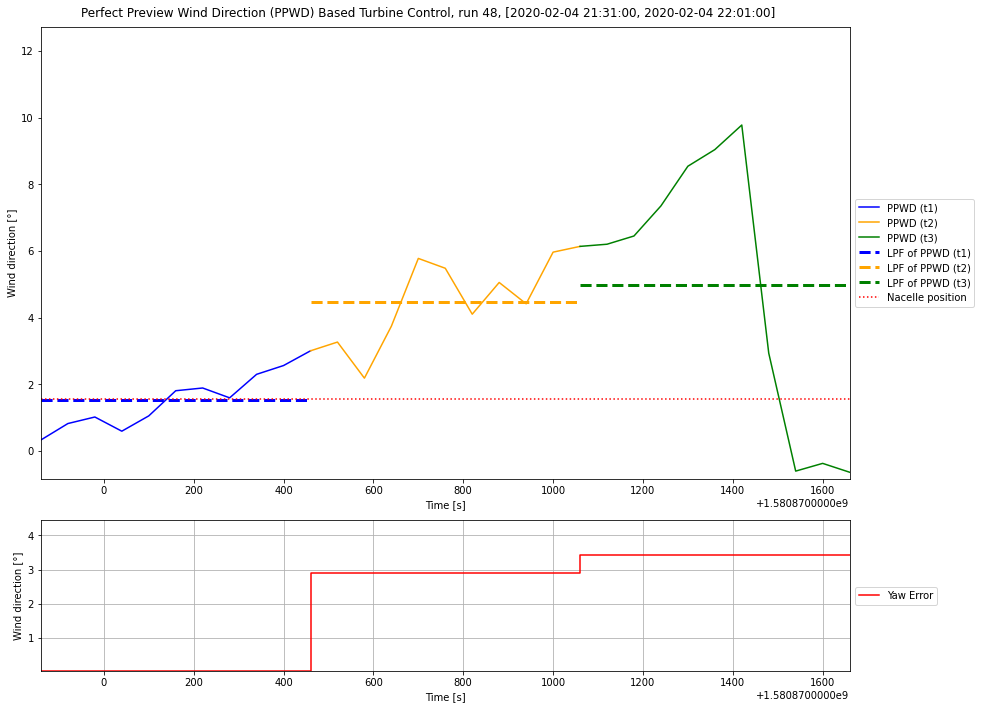

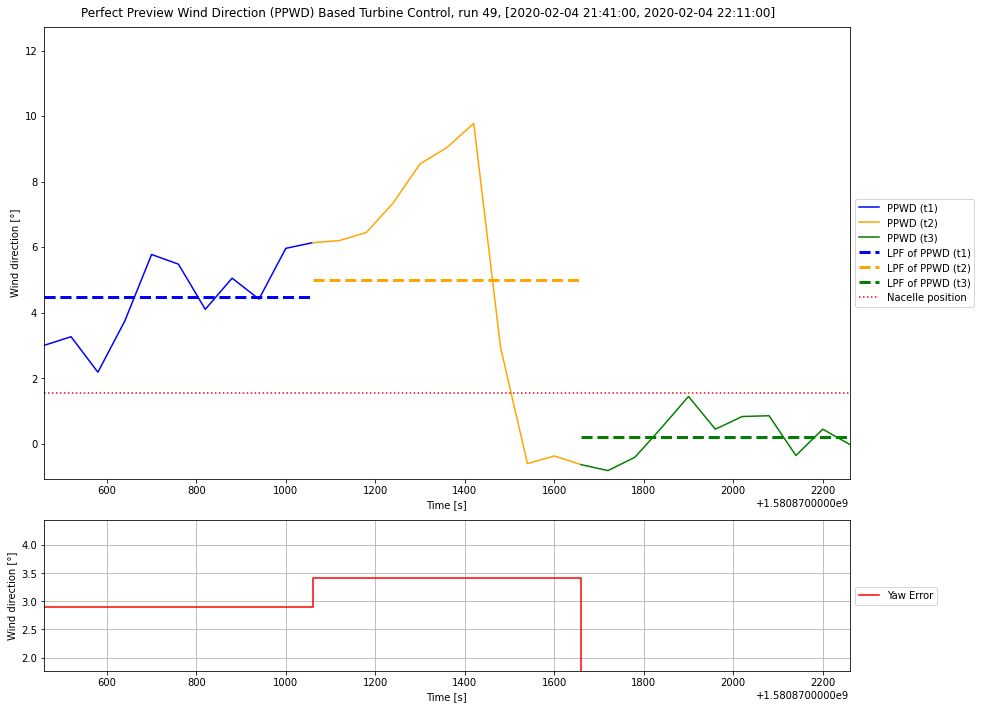

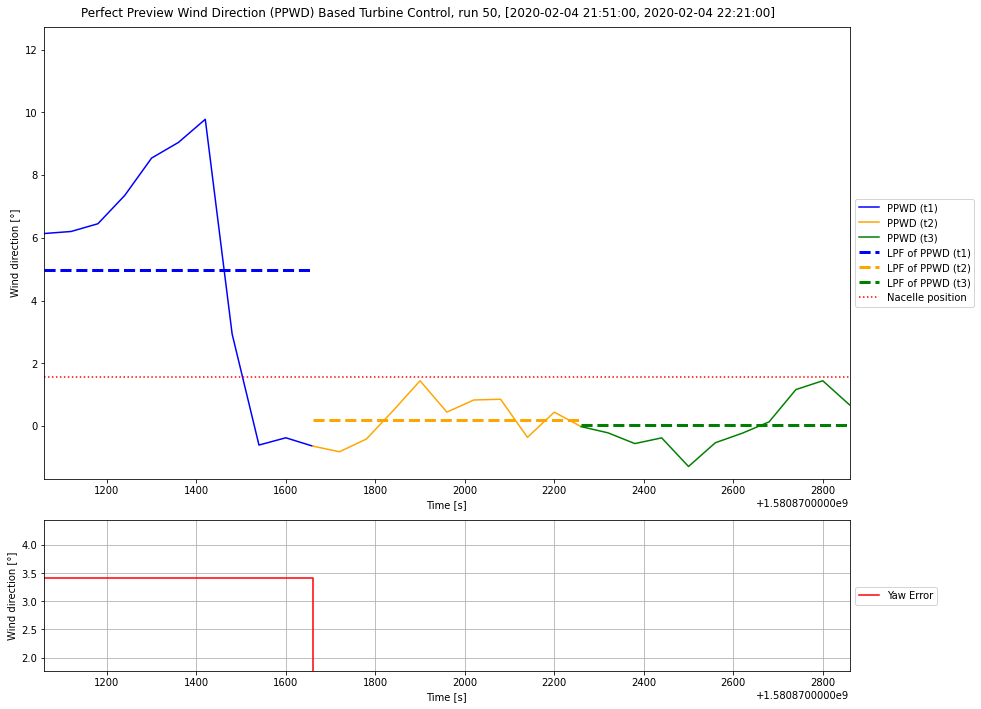

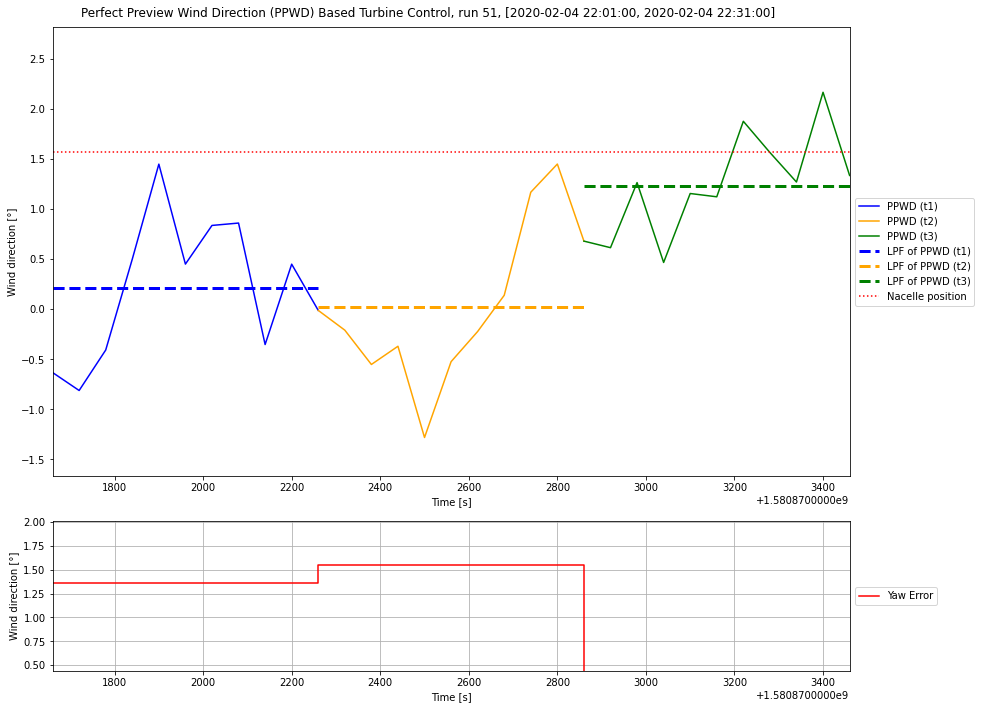

In [433]:
plot_turbine_reactions(perfect_preview_update_schedule_df, field_temporal_resolution)

#### Finding effect of magnitude of T on results

In [4]:
def duty_T_grid_search(data_df, T_range, field_temporal_resolution, deg_threshold, turbine_rotation_speed, control_type="standard"):
    duties = []
    schedules = []
    for T in T_range:
        perfect_preview_update_schedule_df_i, duty_i = perfect_preview_control(data_df=field_data_df, T=T, deg_threshold=deg_threshold,turbine_rot_speed=turbine_rotation_speed,control_type=control_type)
        duties.append(duty_i)
        schedules.append(perfect_preview_update_schedule_df_i)
       
    return duties, schedules

In [8]:
field_temporal_resolution = 60 # [seconds]
deg_threshold = 6 # degrees
turbine_rotation_speed = 0.3
control_type = "standard"

In [ ]:
T_range = [field_temporal_resolution*i for i in range(3, 20)] # [3 mins, 20 mins] in seconds
turbines = ["BHR58", "BHR59", "BHR62"]
results = {}
for turbine in turbines:
    field_data_filepath = f"../data/Field data/{turbine}.csv" 
    raw_field_data_df = pd.read_csv(f"{field_data_filepath}") #.rename(columns={"Unnamed: 0": "t"})
    field_data_df = raw_field_data_df[["t", "RelWndDir"]].rename(columns={"RelWndDir": "wind_direction"})
    duties, schedules = duty_T_grid_search(field_data_df, T_range, field_temporal_resolution, deg_threshold, turbine_rotation_speed, control_type)

    results[turbine] = (duties, schedules)

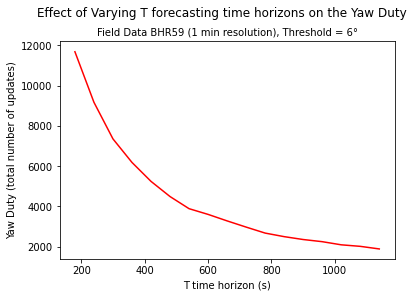

<Figure size 432x288 with 0 Axes>

In [ ]:
colors = ["blue", "red", "green", "orange"]
for i in range(len(turbines)):
    turbine = turbines[i]
    duties_i, schedules_i = results[turbine]
    color = colors[i]
    plt.plot(T_range, duties_i, color=color, label=turbine)
plt.suptitle("Effect of Varying T forecasting time horizons on the Yaw Duty", y=1, fontsize=12)
plt.title(f"Field Data (1 min resolution), Threshold = {deg_threshold}°", fontsize=10)
plt.xlabel("T time horizon (s)")
plt.ylabel("Yaw Duty (total number of updates)")
plt.ylim(top=12200)
plt.show()
plt.savefig(f"allFieldData_{control_type}_yawDuty_T_threshold={deg_threshold}.png")

In [3]:
# find the hourly duty 
def get_mean_hourly_duty(schedule_df):
    
    def convert_timestamps_to_datetime(schedule_df):
        schedule_df["Start datetime"] = [dt.fromtimestamp(t_0) for t_0 in schedule_df["T_initial"].values]
        schedule_df["End datetime"] = [dt.fromtimestamp(t_f) for t_f in schedule_df["T_final"].values]
        return schedule_df
    
    schedule_df = convert_timestamps_to_datetime(schedule_df)
    # identify month, day, hour of timestamps
    schedule_df["Month"] = schedule_df["Start datetime"].dt.month
    schedule_df["Day"] = schedule_df["Start datetime"].dt.day
    schedule_df["Hour"] = schedule_df["Start datetime"].dt.hour
    # add counter of whether duty occured (T = 1, F = 0)
    schedule_df["Duty"] = schedule_df["Nacelle Position Update (T/F)"].astype(int)
    # get mean hourly duty across entire schedule
    average_hourly_duty = schedule_df.groupby(by=["Month", "Day", "Hour"]).sum().mean()["Duty"]    
    return average_hourly_duty

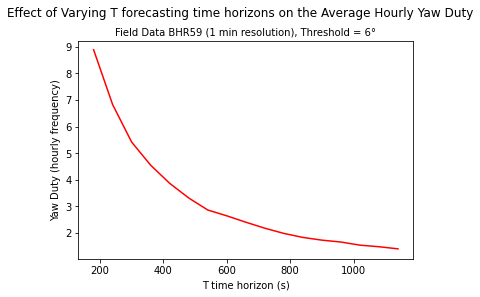

<Figure size 432x288 with 0 Axes>

In [272]:
colors = ["blue", "red", "green", "orange"]
for i in range(len(turbines)):
    turbine = turbines[i]
    duties_i, schedules_i = results[turbine]
    hourly_duties_i = [get_mean_hourly_duty(schedule_df=schedule_i) for schedule_i in schedules]
    color = colors[i]
    plt.plot(T_range, hourly_duties_i, color=color, label=turbine)
plt.suptitle("Effect of Varying T forecasting time horizons on the Average Hourly Yaw Duty", y=1, fontsize=12)
plt.title(f"Field Data (1 min resolution), Threshold = {deg_threshold}°", fontsize=10)
plt.xlabel("T time horizon (s)")
plt.ylabel("Yaw Duty (hourly frequency)")
plt.ylim(top=9.2)
plt.show()
plt.savefig(f"allFieldData_{control_type}_avgHourlyYawDuty_T_threshold={deg_threshold}.png")

#### Calculating the Yaw Error

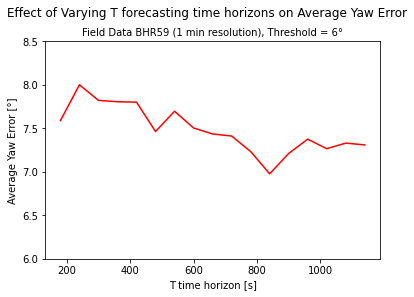

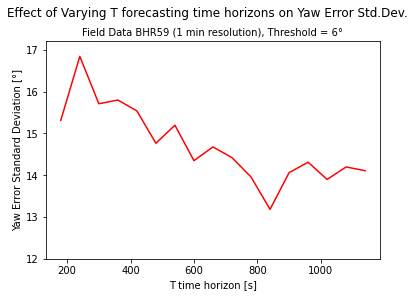

In [305]:
mean_yaw_errors = []
std_dev_yaw_errors = []
for schedule in schedules:
    mean_yew_error_i = np.mean(schedule["Delta Degree"])
    mean_yaw_errors.append(mean_yew_error_i)
    std_dev_yaw_error_i = np.std(schedule["Delta Degree"])
    std_dev_yaw_errors.append(std_dev_yaw_error_i)

plt.plot(T_range, mean_yaw_errors,color="red")
plt.suptitle("Effect of Varying T forecasting time horizons on Average Yaw Error", y=1, fontsize=12)
plt.title(f"Field Data {turbine} (1 min resolution), Threshold = {deg_threshold}°", fontsize=10)
plt.xlabel("T time horizon [s]")
plt.ylabel("Average Yaw Error [°]")
plt.ylim((6.0, 8.5))
plt.savefig(f"{turbine}_standard_avgYawError_T_threshold=6.png")
plt.show()

plt.plot(T_range, std_dev_yaw_errors,color="red")
plt.suptitle("Effect of Varying T forecasting time horizons on Yaw Error Std.Dev.", y=1, fontsize=12)
plt.title(f"Field Data {turbine} (1 min resolution), Threshold = {deg_threshold}°", fontsize=10)
plt.xlabel("T time horizon [s]")
plt.ylabel("Yaw Error Standard Deviation [°]")
plt.ylim((12.0, 17.2))

plt.savefig(f"allFieldData_{control_type}_stdDevYawError_T_threshold={deg_threshold}.png")
plt.show()

#### Scalable T grid Search Functions

In [14]:
def plot_grid_search_results(results, deg_threshold, turbine_rotation_speed, control_type, graph_title="allFieldData"):
    turbines = list(results.keys())
    colors = ["blue", "red", "green", "orange"]
    metrics = ["Yaw Duty", "Mean Hourly Yaw Duty", "Mean Yaw Error", "Std Dev Yaw Error"]
    for metric in metrics:
        plt.figure(figsize=(7,5))
        for i in range(len(turbines)):
            turbine = turbines[i]
            duties_i, schedules_i = results[turbine]
            color = colors[i]

            if metric == "Yaw Duty":
                plt.plot(T_range, duties_i, color=color, label=turbine)
            
            elif metric == "Mean Hourly Yaw Duty":
                hourly_duties_i = [get_mean_hourly_duty(schedule_df=schedule_i) for schedule_i in schedules]
                plt.plot(T_range, hourly_duties_i, color=color, label=turbine)

            else:
                mean_yaw_errors = []
                std_dev_yaw_errors = []
                for schedule in schedules:
                    mean_yew_error_i = np.mean(schedule["Delta Degree"])
                    mean_yaw_errors.append(mean_yew_error_i)
                    std_dev_yaw_error_i = np.std(schedule["Delta Degree"])
                    std_dev_yaw_errors.append(std_dev_yaw_error_i)
                if metric == "Mean Yaw Error": 
                    plt.plot(T_range, mean_yaw_errors, color=color, label=turbine)
                
                elif metric == "Std Dev Yaw Error":
                    plt.plot(T_range, std_dev_yaw_errors, color=color, label=turbine)

        plt.suptitle(f"Effect of Varying T Forecasting Horizons on the {metric}", y=1, fontsize=12)
        plt.title(f"Field Data (1 min resolution) [threshold[°]={deg_threshold}°, control={control_type}, rot.speed[°/s]={turbine_rotation_speed},]", fontsize=10)
        plt.xlabel("T time horizon (s)")
        plt.ylabel(f"{metric}")
        plt.savefig(f"{graph_title}_{control_type}_{metric.strip()}_T_threshold={deg_threshold}")
        plt.show()


In [15]:
def field_data_grid_search(turbines = ["BHR58"], deg_threshold=0.6, turbine_rotation_speed=0.3, control_type="standard", graph_title=None):
    ''' 
    param turbines : [str] : list of the names/labels of turbines in the western india wind farm
    param deg_threshold : float : the threshold of delta degree the turbine should change nacelle position
    param turbine_rotation_speed : float : the speed at which the nacelle changes direction
    param control_type : str : {"standard", "wake steering}
    param graph_title : str : custome title to include in the final plot
    '''
    results = {}
    # iterate over turbines to open datasets
    for turbine in turbines:
        try: 
            field_data_filepath = f"../data/Field data/{turbine}.csv" 
            raw_field_data_df = pd.read_csv(f"{field_data_filepath}") #.rename(columns={"Unnamed: 0": "t"})
            field_data_df = raw_field_data_df[["t", "RelWndDir"]].rename(columns={"RelWndDir": "wind_direction"})
            # find the limits
            T_range = [field_temporal_resolution*(field_data_df.shape[0]/i) for i in range(1,field_data_df.shape[0])]

            duties, schedules = duty_T_grid_search(field_data_df, T_range, field_temporal_resolution, deg_threshold, turbine_rotation_speed, control_type)

            results[turbine] = (duties, schedules)
        except Exception as e:
            print(e)
            continue
    try:   
        plot_grid_search_results(results, deg_threshold, turbine_rotation_speed, control_type, graph_title=graph_title+turbine)
    except Exception as e:
        print("Error plotting: ", e)

    return results

In [16]:
tubines = ["BHR58"]
field_temporal_resolution = 60 # [seconds]
deg_threshold = 6 # degrees
turbine_rotation_speed = 0.3
control_type = "standard"
results = field_data_grid_search(tubines, deg_threshold, turbine_rotation_speed, control_type)

: 

: 

In [ ]:
turbines = ["BHR59"]
field_temporal_resolution = 60 # [seconds]
deg_threshold = 6 # degrees
turbine_rotation_speed = 0.3
control_type = "standard"
results_59 = field_data_grid_search(turbines, deg_threshold, turbine_rotation_speed, control_type)

In [ ]:
turbines = ["BHR62"]
field_temporal_resolution = 60 # [seconds]
deg_threshold = 6 # degrees
turbine_rotation_speed = 0.3
control_type = "standard"
results_62 = field_data_grid_search(tubines, deg_threshold, turbine_rotation_speed, control_type)

In [321]:
len(results['BHR58'][1])

17

In [313]:
results['BHR59'][1][0]

,Interval,T_initial,T_final,Perfect Preview Wind Direction (PPWD) (phi(t)),Low-pass-filter of PPWD (mean phi),Nacelle position (theta(t)),Delta Degree,Nacelle Position Update (T/F),Nacelle Repositioning Duration (s)
0,0,1580841060,1580841240,"[7.217131059677874, 5.246912498943141, 6.57855...",6.347532,7.217131,0.869599,False,0
1,1,1580841240,1580841420,"[8.543743133544922, 10.32696717293536, 10.9365...",9.935765,7.217131,2.718634,False,0
2,2,1580841420,1580841600,"[11.66612006797165, 9.725163866261967, 10.6971...",10.696157,7.217131,3.479025,False,0
3,3,1580841600,1580841780,"[9.27949997584025, 11.02218581809372, 12.62631...",10.975999,7.217131,3.758868,False,0
4,4,1580841780,1580841960,"[10.657759525736823, 12.118415246244338, 14.94...",12.575064,7.217131,5.357933,False,0
...,...,...,...,...,...,...,...,...,...
44408,32724,1586731380,1586731560,"[5.351038174551041, 7.14016393755303, 7.773401...",6.754868,2.644472,4.110396,False,0
44409,32725,1586731560,1586731740,"[9.192390637319596, 10.4790572572927, 6.032800...",8.568083,2.644472,5.923611,False,0
44410,32726,1586731740,1586731920,"[2.759603781778304, 0.3378055175145467, 5.3584...",2.818622,2.644472,0.174150,False,0
44411,32727,1586731920,1586732100,"[1.94964476100734, 3.141816936555456, 1.738688...",2.276717,2.644472,0.367755,False,0


In [314]:
results['BHR62'][1][0]

,Interval,T_initial,T_final,Perfect Preview Wind Direction (PPWD) (phi(t)),Low-pass-filter of PPWD (mean phi),Nacelle position (theta(t)),Delta Degree,Nacelle Position Update (T/F),Nacelle Repositioning Duration (s)
0,0,1580841060,1580841240,"[7.217131059677874, 5.246912498943141, 6.57855...",6.347532,7.217131,0.869599,False,0
1,1,1580841240,1580841420,"[8.543743133544922, 10.32696717293536, 10.9365...",9.935765,7.217131,2.718634,False,0
2,2,1580841420,1580841600,"[11.66612006797165, 9.725163866261967, 10.6971...",10.696157,7.217131,3.479025,False,0
3,3,1580841600,1580841780,"[9.27949997584025, 11.02218581809372, 12.62631...",10.975999,7.217131,3.758868,False,0
4,4,1580841780,1580841960,"[10.657759525736823, 12.118415246244338, 14.94...",12.575064,7.217131,5.357933,False,0
...,...,...,...,...,...,...,...,...,...
44408,32724,1586731380,1586731560,"[5.351038174551041, 7.14016393755303, 7.773401...",6.754868,2.644472,4.110396,False,0
44409,32725,1586731560,1586731740,"[9.192390637319596, 10.4790572572927, 6.032800...",8.568083,2.644472,5.923611,False,0
44410,32726,1586731740,1586731920,"[2.759603781778304, 0.3378055175145467, 5.3584...",2.818622,2.644472,0.174150,False,0
44411,32727,1586731920,1586732100,"[1.94964476100734, 3.141816936555456, 1.738688...",2.276717,2.644472,0.367755,False,0
